In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/oral-cancer-dataset-all-unlabeled'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Install dependencies

In [2]:
!pip install torch torchvision matplotlib numpy tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

# modifying imports and adding glob for file handling

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models, transforms
import torchvision.models as models
from torchvision.models import efficientnet_b0
import torchvision.transforms as T
import torchvision.transforms.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import glob

# Checking the dataset name

In [4]:
!ls /kaggle/input/

'all unlabeled'


# Custom dataset for pretraining (unlabeled)

In [5]:
class OralCancerSimCLRDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.image_paths = glob.glob(os.path.join(data_path, '*.jpg'))
        if not self.image_paths:
            raise ValueError(f"No .jpg images found in {data_path}. Check the path.")
        print(f"Found {len(self.image_paths)} images in {data_path}")
        self.transform = transform
        self.labels = []
        for path in self.image_paths:
            filename = os.path.basename(path).lower()
            if 'scc' in filename or 'cancer' in filename:
                self.labels.append(1)  # Cancer
            elif 'normal' in filename or 'non' in filename:
                self.labels.append(0)  # Non-cancer
            else:
                raise ValueError(f"Could not infer label for {filename}. Check filename format.")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img1 = self.transform(img)  # First augmented view
            img2 = self.transform(img)  # Second augmented view
            return img1, img2, label
        return img, img, label

# Custom dataset for downstream classification

In [6]:
class OralCancerDownstreamDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.image_paths = glob.glob(os.path.join(data_path, '*.jpg'))
        if not self.image_paths:
            raise ValueError(f"No .jpg images found in {data_path}. Check the path.")
        print(f"Found {len(self.image_paths)} images in {data_path}")
        self.transform = transform
        self.labels = []
        for path in self.image_paths:
            filename = os.path.basename(path).lower()
            if 'scc' in filename:
                self.labels.append(1)  # Cancer
            elif 'normal' in filename:
                self.labels.append(0)  # Non-cancer
            else:
                raise ValueError(f"Could not infer label for {filename}. Check filename format.")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Transforms

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B0 224x224
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

downstream_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Oral Cancer dataset for pretraining

In [9]:
data_path = '/kaggle/input/all unlabeled'
if not os.path.exists(data_path):
    raise ValueError(f"Data path {data_path} does not exist. Run '!ls /kaggle/input/' to check.")
print(f"Loading dataset from {data_path}")
train_dataset = OralCancerSimCLRDataset(data_path=data_path, transform=transform)
print(f"Found {len(train_dataset)} images")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

Loading dataset from /kaggle/input/all unlabeled
Found 10002 images in /kaggle/input/all unlabeled
Found 10002 images


In [10]:
for batch in train_loader:
    img1, img2, labels = batch
    print(f"Batch - img1 shape: {img1.shape}, img2 shape: {img2.shape}, labels shape: {labels.shape}")
    break

Batch - img1 shape: torch.Size([64, 3, 224, 224]), img2 shape: torch.Size([64, 3, 224, 224]), labels shape: torch.Size([64])


# SimCLR model

In [11]:
class SimCLR(nn.Module): 
    def __init__(self, feature_dim=128): 
        super(SimCLR, self).__init__()

        # Backbone encoder (EfficientNet-B0)
        self.f = models.efficientnet_b0(weights=None)
        self.f.classifier = nn.Identity()  # Remove the final classifier layer

        # Projection head (MLP) - input dim is 1280 for EfficientNet-B0
        self.g = nn.Sequential(
            nn.Linear(1280, 512, bias=False),  
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Linear(512, feature_dim, bias=True)
        )

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.g(feature)
        return torch.nn.functional.normalize(out, dim=-1)
    
    @property
    def encoder(self):
        return self.f  # The backbone without projection head

# Initialize model

In [12]:
model = SimCLR(feature_dim=128)  # Initialize with default feature_dim

# NT-Xent loss

In [13]:
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)
    z = torch.nn.functional.normalize(z, dim=1, p=2)  # L2 normalization
    print(f"Normalized z shape: {z.shape}")  # Debug shape
    similarity = torch.matmul(z, z.T) / temperature
    print(f"Similarity shape: {similarity.shape}")  # Debug shape
    labels = torch.arange(batch_size).to(z.device)
    labels = torch.cat([labels, labels], dim=0)
    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)
    similarity = similarity.masked_fill(mask, -9e15)
    # Compute positives for all samples
    positives = torch.zeros(2 * batch_size).to(z.device)
    for i in range(batch_size):
        positives[i] = similarity[i, batch_size + i]  # z1[i] vs z2[i]
        positives[batch_size + i] = similarity[batch_size + i, i]  # z2[i] vs z1[i]
    numerator = torch.exp(positives)
    mask_positives = torch.zeros(2 * batch_size, 2 * batch_size, dtype=torch.bool).to(z.device)
    for i in range(batch_size):
        mask_positives[i, batch_size + i] = True
        mask_positives[batch_size + i, i] = True
    denominator = torch.exp(similarity).masked_fill(mask_positives, 0).sum(dim=1)
    loss = -torch.log(numerator / (denominator + 1e-8)).mean()  # Add small epsilon to avoid log(0)
    return loss

# Device setup

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


# Pretext training

In [15]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
save_dir = '/kaggle/working'
os.makedirs(save_dir, exist_ok=True)
pretext_losses = []
for epoch in range(100):
    model.train()
    total_loss = 0
    for img1, img2, _ in tqdm(train_loader):  # Ignore labels for pretraining
        img1, img2 = img1.to(device), img2.to(device)
        z1 = model(img1)
        z2 = model(img2)
        loss = nt_xent_loss(z1, z2)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    pretext_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}] Pretext Loss: {avg_loss}")
    model_path = os.path.join(save_dir, 'simclr_pretask_efficientnetb0.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:03<10:22,  3.99s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:04<04:53,  1.89s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:04<03:11,  1.24s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:05<02:20,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:06<02:53,  1.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:07<02:15,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:08<02:43,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:09<02:11,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:10<02:44,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:11<02:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:12<02:39,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:13<02:09,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:14<02:36,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:15<02:07,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:16<02:39,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:17<02:08,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:18<02:42,  1.16s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:19<02:10,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:20<02:34,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:21<02:05,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:23<02:33,  1.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:23<02:04,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:25<02:29,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:25<02:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:26<02:22,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:27<01:55,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:28<02:20,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:29<01:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:30<02:18,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:31<01:52,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:32<02:17,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:33<01:51,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:34<02:15,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:35<01:49,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:36<02:09,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:37<01:45,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:38<02:09,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:39<01:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:40<02:08,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:41<01:43,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:42<02:09,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:43<01:44,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:44<02:04,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:45<01:40,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:46<02:02,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:47<01:39,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:48<02:03,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:49<01:39,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:50<02:04,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:51<01:40,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:52<01:56,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:53<01:34,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:54<01:49,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:55<01:29,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:56<01:53,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:57<01:31,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:58<01:49,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:59<01:28,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [01:00<01:46,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [01:01<01:26,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [01:02<01:45,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [01:03<01:25,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [01:04<01:40,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [01:05<01:21,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [01:06<01:37,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [01:06<01:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [01:08<01:33,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [01:08<01:16,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [01:10<01:31,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [01:10<01:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:12<01:31,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:12<01:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:14<01:32,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:14<01:14,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:16<01:30,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:16<01:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:18<01:29,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:18<01:12,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:20<01:25,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:20<01:09,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:22<01:29,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:23<01:11,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:24<01:25,  1.16s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:25<01:08,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:26<01:22,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:27<01:06,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:28<01:18,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:29<01:02,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:30<01:13,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:31<00:59,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:32<01:11,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:33<00:57,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:34<01:11,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:35<00:57,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:36<01:07,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:37<00:54,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:38<01:03,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:38<00:51,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:40<01:00,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:40<00:48,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:42<00:58,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:42<00:47,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:44<00:56,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:44<00:45,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:46<00:54,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:46<00:44,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:48<00:53,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:48<00:42,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:50<00:51,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:50<00:40,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:52<00:49,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:52<00:39,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:54<00:47,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:54<00:38,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:56<00:46,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:56<00:36,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:57<00:42,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:58<00:33,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:59<00:39,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [02:00<00:32,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [02:01<00:38,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [02:02<00:30,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [02:03<00:35,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [02:04<00:28,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [02:05<00:33,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [02:05<00:26,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [02:07<00:32,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [02:08<00:25,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [02:09<00:30,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [02:10<00:24,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [02:11<00:28,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [02:12<00:22,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [02:13<00:26,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [02:14<00:20,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [02:15<00:24,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [02:16<00:19,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [02:17<00:21,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [02:18<00:16,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [02:19<00:19,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [02:19<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [02:21<00:17,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [02:21<00:13,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:23<00:15,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:23<00:11,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:25<00:13,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:25<00:09,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:27<00:11,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:28<00:08,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:29<00:08,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:29<00:06,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:31<00:06,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:31<00:04,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:33<00:04,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:33<00:02,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:35<00:02,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:36<00:00,  1.01it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [1] Pretext Loss: 4.377547168427972


Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:20,  2.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:58,  1.16s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:32,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:02,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:20,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:11,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:49,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:07,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:47,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:45,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:43,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:56,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:37,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:00,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:40,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:53,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:35,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<02:05,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:43,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:50,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:33,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:53,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:34,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:46,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:29,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:44,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:28,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:43,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:41,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:25,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:18,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:26,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:13,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:32,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:34,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:18,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:33,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:17,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:28,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:13,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:28,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:13,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:26,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:22,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:28,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:12,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:22,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:08,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:21,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:07,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:14,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:01,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:59,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:11,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:59,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:11,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:59,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:55,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:03,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:53,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:00,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:50,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:51,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:02,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:58,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:48,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:59,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:48,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:57,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:47,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:55,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:45,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:52,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:43,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:51,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:42,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:52,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:42,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:51,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:42,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:46,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:38,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:43,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:42,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:35,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:41,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:33,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:31,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:36,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:33,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:32,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:26,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:42<00:29,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:24,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:28,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:23,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:46<00:27,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:22,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:24,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:20,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:23,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:18,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:20,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:51<00:16,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:20,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:53<00:16,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:15,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:56<00:12,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:57<00:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:58<00:11,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:59<00:14,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:00<00:10,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:01<00:11,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:08,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:03<00:09,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:03<00:07,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:04<00:07,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:05<00:05,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:06<00:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:06<00:03,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:07<00:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:08<00:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:09<00:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:10<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [2] Pretext Loss: 3.6464522203822045
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:25,  2.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:52,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:03,  1.19s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:39,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:07,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:25,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:59,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:11,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:49,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:06,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:46,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:06,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:45,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:06,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:45,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:02,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<02:13,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:49,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<02:03,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:42,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<02:00,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:40,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:46,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:30,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:42,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:43,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:28,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:41,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:36,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:30,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:34,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:27,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:29,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:30,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:29,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:28,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:25,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:26,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:27,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:30,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:28,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:26,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:19,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:25,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:19,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:24,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:13,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:23,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:10,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:28,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:15,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:26,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:11,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:07,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:24,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:09,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:17,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:04,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:02,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:01,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:09,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<00:58,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:07,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:07<00:56,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:54,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:53,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:04,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:53,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<01:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<00:59,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<00:58,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:49,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:54,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:46,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:45,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:53,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:44,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:51,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:42,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:52,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:43,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:56,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:27<00:45,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:51,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:41,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:30<00:48,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:39,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:32<00:46,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:32<00:37,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:33<00:42,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:34<00:35,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:35<00:37,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:38,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:37<00:31,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:38<00:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:39<00:29,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:40<00:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:29,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:32,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:42<00:28,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:31,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:44<00:25,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:45<00:30,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:24,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:47<00:28,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:47<00:23,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:49<00:27,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:49<00:21,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:50<00:25,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:51<00:20,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:52<00:23,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:53<00:18,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:54<00:21,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:54<00:17,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:56<00:18,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:56<00:14,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:57<00:17,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:58<00:13,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:59<00:15,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [02:00<00:12,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:01<00:13,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:01<00:10,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:03<00:11,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:03<00:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:04<00:09,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:05<00:07,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:06<00:07,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:06<00:05,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:08<00:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:08<00:03,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:09<00:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:10<00:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:11<00:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:12<00:00,  1.19it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [3] Pretext Loss: 3.387749805571927
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:26,  2.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:52,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:45,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:05,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:28,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:59,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:13,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:50,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:16,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:48,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:48,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:07,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:04,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:44,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:13,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:50,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:10,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:47,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<02:04,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:43,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<02:00,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:39,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:56,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:37,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:55,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:35,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:55,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:36,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:53,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:34,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:50,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:32,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:34<01:48,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:30,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:46,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:36<01:28,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:40,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:34,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:20,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:33,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:18,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:20,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:35,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:19,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:47<01:33,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:17,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:30,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:15,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:40,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:51<01:21,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:52<01:31,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:15,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:54<01:26,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:11,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:25,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:56<01:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:57<01:19,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:13,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:02,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:19,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:01<01:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:02<01:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:01,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:04<00:59,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:09,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<00:58,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:05,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:07<00:55,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:03,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:53,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:00,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:51,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:12<00:51,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<01:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:50,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:02,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<01:02,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:17<00:51,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:58,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:20<00:57,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:47,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:54,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:22<00:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:58,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:24<00:47,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:25<00:53,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:44,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:27<00:50,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:27<00:41,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:47,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:29<00:39,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:30<00:45,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:37,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:32<00:42,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:32<00:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:33<00:40,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:34<00:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:35<00:41,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:33,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:37<00:38,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:37<00:31,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:38<00:35,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:39<00:29,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:40<00:34,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:27,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:42<00:33,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:42<00:27,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:31,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:44<00:25,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:45<00:28,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:23,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:47<00:25,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:47<00:20,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:24,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:49<00:20,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:50<00:22,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:50<00:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:52<00:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:52<00:17,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:53<00:19,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:54<00:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:55<00:20,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:56<00:15,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:57<00:17,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:57<00:14,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:59<00:15,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:59<00:12,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:00<00:13,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:01<00:10,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:02<00:11,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:03<00:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:04<00:09,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:04<00:07,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:06<00:07,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:06<00:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:07<00:05,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:07<00:03,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:09<00:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:09<00:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:10<00:01,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:11<00:00,  1.19it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [4] Pretext Loss: 3.261261959744107
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:24,  2.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:04,  1.20s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:17,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:27,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:58,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:19,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:14,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:52,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:09,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:48,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:09,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:47,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:12,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:49,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:06,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:44,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:06,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:45,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<02:00,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:40,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:57,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:37,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<02:01,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:40,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:55,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:36,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:29<01:57,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:37,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:48,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:50,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:32,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:42,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:26,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:36,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:21,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:38,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:35,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:23,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:36,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:21,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:30,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:21,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:27,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:23,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:25,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:22,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:23,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:19,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:26,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:28,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:25,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:51<01:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:15,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:22,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:13,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:19,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:11,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:17,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:06,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:20,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:07,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:02<01:20,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:06,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:12,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:04<01:03,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:09,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<01:02,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:07<01:01,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:01,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:09<00:59,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:10<01:02,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:59,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<00:58,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:12<00:57,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<00:55,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:14<00:57,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<00:56,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:56,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<00:52,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:17<00:53,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:50,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:19<00:51,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:49,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:52,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:54,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:22<00:49,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:50,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:24<00:46,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:46,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:46,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:41,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:27<00:44,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:38,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:29<00:45,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:38,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:43,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:32<00:41,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:38,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:32,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:36,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:30,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:37<00:35,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:29,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:34,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:28,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:31,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:26,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:42<00:30,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:42<00:25,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:29,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:28,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:45<00:23,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:47<00:26,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:21,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:24,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:19,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:50<00:22,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:18,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:52<00:20,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:16,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:53<00:19,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:15,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:55<00:17,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:13,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:57<00:15,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:57<00:12,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:58<00:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:59<00:10,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:00<00:11,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:08,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:09,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:02<00:07,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:03<00:07,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:05,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:05,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:04,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:06<00:04,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:02,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:08<00:01,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [5] Pretext Loss: 3.1815557730425694
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:25,  2.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:52,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:46,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:06,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:04<02:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:55,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:07,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:49,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:09<02:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:52,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:52,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<01:58,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:51,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<02:04,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<02:04,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:06,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:57,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:45,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:42,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:36,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:48,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:32,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:32,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:45,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:31,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:43,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:31,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:40,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:29,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:41,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:26,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:37,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:26,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:38,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:23,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:33,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:27,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:34,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:24,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:30,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:24,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:31,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:24,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:26,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:22,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:23,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:14,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:25,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:16,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:29,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:37,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:20,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:28,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:13,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:21,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:10,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:19,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:15,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:09,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:13,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:09,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:08,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:07,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:09,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:06,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:04,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:02,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:59,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:04,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:05,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:55,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:52,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:59,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:50,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<01:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:50,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:57,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:48,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:55,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:46,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:56,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:47,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:59,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:48,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:55,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:45,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:54,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:44,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:50,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:41,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:45,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:37,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:44,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:37,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:43,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:35,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:40,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:38,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:31,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:37,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:34,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:34,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:28,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:33,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:26,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:27,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:24,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:20,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:22,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:18,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:20,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:17,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:20,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:16,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:18,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:19,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:15,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:17,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:13,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:10,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:09,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:07,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [6] Pretext Loss: 3.132586918059428
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:20,  2.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:49,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:03,  1.19s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:30,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:00,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:31,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:03,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:13,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:51,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:50,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:51,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:48,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:41,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:19,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:54,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<02:08,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:46,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:04,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:43,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<02:01,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:40,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<01:59,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:40,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:52,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:45,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:29,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:46,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:29,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:45,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:40,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:24,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:37,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:22,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:40,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:38,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:23,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:32,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:18,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:29,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:15,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:19,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:29,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:15,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:26,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:12,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:26,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:12,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:39,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:21,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:32,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:16,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:28,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:13,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:21,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:07,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:18,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:15,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:03,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:12,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:01,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:11,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:00,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:08,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:57,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:10,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:58,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:05,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:55,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:03,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:53,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<00:59,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:50,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:00,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:51,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:50,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<01:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:46,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:53,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:45,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:52,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:43,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:50,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:42,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:57,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:47,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:50,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:48,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:46,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:38,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:46,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:38,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:42,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:35,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:39,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:32,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:39,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:37,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:30,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:27,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:30,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:25,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:29,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:23,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:28,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:27,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:22,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:24,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:19,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:24,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:19,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:17,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:20,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:16,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:18,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:15,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:17,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:13,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:57<00:11,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:08,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:07,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [7] Pretext Loss: 3.1007600840489578
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:31,  2.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:55,  1.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:01,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:24,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:56,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:13,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:50,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:03,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:44,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:09<01:56,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:39,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:01,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:11<01:42,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:12<02:00,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:41,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<02:02,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:42,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:18,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:53,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:09,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:47,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:55,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:37,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:56,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:37,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:58,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:38,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:56,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:36,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:48,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:31,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:42,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:27,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:38,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:23,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:42,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:25,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:34,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:20,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:33,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:19,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:30,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:16,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:32,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:18,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:20,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:42,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:24,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:38,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:22,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:36,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:20,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:35,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:18,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:36,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:19,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:32,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:16,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:29,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:13,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:27,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:12,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:27,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:12,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:21,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:23,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:08,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:18,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:04,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:02,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:09,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<00:57,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:07,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:07<00:56,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:04,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:54,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:01,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:52,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:07,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:55,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<01:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<00:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:46,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:57,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:47,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:56,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:59,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:22<00:48,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:58,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:47,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:25<00:51,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:49,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:27<00:40,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:51,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:29<00:41,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:30<00:49,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:39,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:32<00:46,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:32<00:37,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:33<00:42,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:34<00:34,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:35<00:40,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:36<00:33,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:37<00:38,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:37<00:31,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:38<00:34,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:39<00:28,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:40<00:34,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:28,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:31,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:42<00:25,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:28,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:23,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:45<00:26,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:21,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:46<00:25,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:47<00:21,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:25,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:20,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:50<00:23,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:50<00:19,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:51<00:23,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:52<00:18,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:53<00:22,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:54<00:18,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:55<00:20,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:56<00:16,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:57<00:18,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:58<00:14,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:59<00:15,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:59<00:12,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:00<00:12,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:01<00:10,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:02<00:11,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:03<00:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:04<00:08,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:04<00:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:05<00:07,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:06<00:05,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:07<00:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:07<00:03,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:09<00:03,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:09<00:02,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:11<00:01,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:11<00:00,  1.19it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [8] Pretext Loss: 3.068284568513275
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:33,  2.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:55,  1.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:57,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:39,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:06,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:33,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:04,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:23,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:58,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:22,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:57,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:22,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:13<01:57,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:28,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:15<02:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:16<02:18,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:54,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:18<02:15,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:18<01:51,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<02:04,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:20<01:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:21<01:59,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:40,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:23<02:01,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:23<01:41,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<01:59,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:25<01:39,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:26<02:00,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:27<01:40,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:28<01:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:28<01:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:29<01:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:30<01:33,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:31<01:54,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:32<01:35,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:33<01:45,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:33<01:28,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:34<01:50,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:35<01:31,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:36<01:48,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:37<01:30,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:38<01:39,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:38<01:23,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:39<01:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:40<01:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:41<01:37,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:41<01:22,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:43<01:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:43<01:20,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:44<01:37,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:45<01:21,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:46<01:40,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:47<01:26,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:48<01:39,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:48<01:22,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:50<01:38,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:50<01:21,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:52<01:34,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:52<01:18,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:53<01:26,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:54<01:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:55<01:26,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:55<01:11,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:56<01:23,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:57<01:10,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:58<01:22,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:59<01:09,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [01:00<01:21,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [01:00<01:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:02<01:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:02<01:07,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:03<01:19,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:04<01:05,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:05<01:16,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:06<01:03,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:07<01:11,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:07<00:59,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:08<01:06,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:09<00:56,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:10<01:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:10<00:57,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:12<01:08,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:12<00:58,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:13<01:07,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:14<00:56,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:15<01:06,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:16<00:54,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:17<01:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:17<00:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:19<01:03,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:19<00:52,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:21<01:03,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:21<00:52,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:22<00:57,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:23<00:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:24<00:57,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:24<00:47,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:25<00:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:26<00:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:27<00:49,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:28<00:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:29<00:48,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:29<00:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:30<00:45,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:31<00:37,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:32<00:46,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:33<00:37,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:34<00:41,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:34<00:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:35<00:40,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:36<00:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:37<00:39,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:37<00:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:39<00:37,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:39<00:30,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:40<00:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:41<00:29,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:42<00:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:42<00:27,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:43<00:32,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:44<00:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:45<00:30,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:46<00:25,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:47<00:28,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:47<00:23,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:49<00:27,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:49<00:22,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:50<00:25,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:51<00:21,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:52<00:26,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:53<00:20,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:54<00:22,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:54<00:18,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:55<00:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:56<00:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:57<00:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:57<00:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:59<00:16,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:59<00:13,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [02:01<00:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [02:01<00:11,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:02<00:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:03<00:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:04<00:11,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:04<00:08,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:06<00:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:06<00:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:07<00:06,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:07<00:05,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:09<00:05,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:09<00:03,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:10<00:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:11<00:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:12<00:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:13<00:00,  1.18it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [9] Pretext Loss: 3.0481222549061866
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:17,  2.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:49,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:01,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:26,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:58,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:22,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:19,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:55,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:23,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:58,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:17,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:53,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:44,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<01:59,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:41,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:55,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:37,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:02,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:42,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:03,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:43,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<02:01,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:41,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:59,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:39,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:51,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:46,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:30,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:47,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:45,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:47,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:30,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:29,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:45,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:27,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:46,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:27,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:45,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:27,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:45,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:27,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:20,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:37,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:21,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:37,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:20,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:47<01:36,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:19,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:36,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:19,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:27,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:13,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:52<01:25,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:25,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:11,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:18,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:06,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:15,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:04,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:13,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:04,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:11,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:01,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:10,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:00,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:08,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:57,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:08,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<00:57,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:56,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:56,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:01,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:51,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<00:58,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:49,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<00:59,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:50,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<00:59,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:49,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<01:06,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:54,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<01:01,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:50,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:52,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:43,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:46,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:39,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:44,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:46,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:45,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:38,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:43,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:36,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:42,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:34,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:38,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:32,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:37,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:29,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:35,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:29,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:32,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:27,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:30,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:25,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:29,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:26,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:21,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:26,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:21,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:23,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:19,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:24,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:19,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:22,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:17,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:18,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:07,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:08,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [10] Pretext Loss: 3.03133059231339
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:21,  2.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:49,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:00,  1.17s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:26,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:57,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:51,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:12,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:07,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:47,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:24,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:58,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:19,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:54,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:11,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:49,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<01:59,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:40,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:52,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:35,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:54,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:37,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:56,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:37,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:52,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:35,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:46,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:30,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:49,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:31,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:50,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:33,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:47,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:30,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:46,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:43,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:26,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:41,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:44,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:26,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:21,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:19,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:30,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:16,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:32,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:33,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:19,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:32,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:17,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:28,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:28,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:13,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:26,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:28,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:13,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:24,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:10,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:15,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:03,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:15,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:13,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:01,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:08,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:57,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:06,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:55,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:03,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:54,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:03,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:53,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:53,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:02,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:51,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:50,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<01:00,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:48,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<01:01,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:50,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:59,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:48,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:57,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:47,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:50,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:41,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:46,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:38,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:46,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:38,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:41,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:34,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:41,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:34,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:31,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:34,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:29,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:34,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:33,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:27,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:32,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:27,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:23,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:26,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:21,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:22,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:18,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:23,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:18,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:20,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:16,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:57<00:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:10,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:09,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [11] Pretext Loss: 3.0141688122111523
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:21,  2.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:54,  1.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:11,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:35,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:03,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:28,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:00,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:15,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:52,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:07,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:47,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:09,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:48,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:17,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:53,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:07,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:55,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:37,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:02,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:42,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:51,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:34,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:55,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:37,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:52,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:34,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:48,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:48,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:31,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:47,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:30,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:47,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:50,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:31,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:43,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:26,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:42,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:25,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:39,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:22,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:42,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:24,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:32,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:34,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:19,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:41,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:23,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:31,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:16,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:23,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:18,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:22,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:13,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:16,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:13,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:12,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:12,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:07,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:13,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:11,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:06,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:15,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:04,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:13,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:03,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:13,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<01:03,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:09,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:58,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:04,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:53,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:02,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:52,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<00:58,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:53,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<00:57,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:52,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<01:04,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:57,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<01:04,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:52,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:57,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:47,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:56,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:46,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:54,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:44,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:52,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:43,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:50,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:27<00:41,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:48,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:39,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:30<00:45,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:37,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:45,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:32<00:36,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:33<00:43,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:35,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:35<00:41,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:34,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:38,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:37<00:31,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:38<00:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:29,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:40<00:34,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:28,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:32,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:42<00:26,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:30,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:45<00:28,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:23,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:46<00:25,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:47<00:20,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:22,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:19,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:50<00:26,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:50<00:20,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:51<00:23,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:52<00:18,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:53<00:21,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:54<00:17,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:55<00:17,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:55<00:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:56<00:15,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:57<00:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:58<00:13,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:58<00:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:00<00:11,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:00<00:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:01<00:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:02<00:08,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:03<00:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:04<00:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:05<00:07,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:05<00:05,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:07<00:05,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:07<00:03,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:08<00:03,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:09<00:02,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:10<00:01,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:11<00:00,  1.20it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [12] Pretext Loss: 2.9998853457201817
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:29,  2.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:54,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:02,  1.19s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:36,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:03,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:30,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:02,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:25,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:59,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:11<02:32,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<02:03,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:27,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:13<02:00,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:08,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:46,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:16<02:10,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:48,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:04,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:18<01:44,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<02:08,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:46,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:21<02:05,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:44,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:59,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:23<01:39,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<01:57,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:26<01:48,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:31,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:45,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:29,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:29<01:51,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:33,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:44,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:27,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:47,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:34<01:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:29,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:46,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:36<01:28,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:45,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:38<01:27,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:39<01:45,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:27,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:41<01:44,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:41<01:26,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:41,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:43<01:24,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:44<01:41,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:45<01:23,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:46<01:28,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:46<01:14,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:47<01:26,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:48<01:13,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:49<01:25,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:11,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:25,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:51<01:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:52<01:21,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:08,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:54<01:21,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:08,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:21,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:56<01:08,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:57<01:22,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:08,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:59<01:23,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:08,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:01<01:07,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:02<01:17,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:03<01:03,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:04<01:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:04<01:02,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:06<00:58,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:07<01:10,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:07<00:58,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:09<01:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:09<00:55,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:10<01:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:11<00:53,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:12<01:04,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:12<00:53,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:14<01:02,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:14<00:51,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:15<01:03,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:16<00:52,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:17<00:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:17<00:48,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:55,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:19<00:46,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:20<00:55,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:21<00:46,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:22<00:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:22<00:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:24<00:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:25<00:50,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:41,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:27<00:47,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:27<00:39,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:43,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:29<00:36,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:30<00:42,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:35,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:39,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:32<00:32,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:33<00:36,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:32,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:35,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:31,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:33,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:29,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:32,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:27,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:32,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:26,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:30,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:25,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:42<00:29,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:24,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:28,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:23,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:45<00:26,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:21,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:28,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:22,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:23,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:19,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:51<00:21,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:51<00:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:19,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:53<00:15,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:16,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:13,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:14,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:56<00:12,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:57<00:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:57<00:11,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:59<00:09,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:10,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:07,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:02<00:08,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:06,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:05,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:04,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:08<00:01,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [13] Pretext Loss: 2.986882870364341
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:20,  2.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:45,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:05,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:21,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:54,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:17,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:52,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:19,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:55,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:23,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:58,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:13,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:50,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:10,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:02,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:45,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:00,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:47,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:52,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:45,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:52,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:46,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:44,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:48,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:45,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:47,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:40,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:45,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:38,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:40,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:36,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:35,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:37,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:36,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:39,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:37,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:33,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:31,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:33,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:31,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:31,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:32,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:32,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:28,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:27,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:27,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:24,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:24,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:34,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:26,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:33,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:25,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:29,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:20,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:22,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:18,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:19,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:16,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:20,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:14,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:20,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:08,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:18,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:06,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:17,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:04,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:04,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:03,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:02,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:59,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:06,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:56,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:56,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:02,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:54,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<00:59,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:55,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:58,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:54,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:56,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:52,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:54,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:53,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:55,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:51,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:51,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:47,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:49,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:47,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:44,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:45,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:45,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:43,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:43,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:42,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:41,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:39,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:38,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:38,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:37,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:35,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:36,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:33,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:34,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:30,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:33,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:31,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:31,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:29,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:30,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:28,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:28,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:25,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:27,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:25,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:25,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:22,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:21,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:25,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:20,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:17,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:20,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:16,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:13,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [14] Pretext Loss: 2.978179281684244
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:24,  2.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:52,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:46,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:05,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:29,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:00,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:17,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:53,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:11,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:49,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:09,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:48,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:27,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<02:00,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:17,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:53,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:11,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:49,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:09,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:47,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:57,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:39,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:59,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<02:05,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:43,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:52,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:34,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:55,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:36,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:45,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:29,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:40,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:25,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:42,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:26,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:42,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:26,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:37,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:23,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:38,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:22,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:42,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:25,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:40,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:23,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:42,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:24,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:31,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:39,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:22,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:42,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:24,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:37,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:20,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:32,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:17,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:24,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:10,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:22,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:09,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:23,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:27,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:11,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:26,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:11,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:24,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:09,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:04,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:13,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:01,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:58,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:05,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<00:55,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:06,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:55,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:03,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:53,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:03,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:53,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:52,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:05,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:53,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:04,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:53,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<01:06,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:54,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<01:04,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:52,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:20<01:01,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:49,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:55,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:22<00:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:51,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:42,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:25<00:50,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:41,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:46,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:38,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:45,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:37,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:44,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:32<00:36,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:33<00:39,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:33,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:37,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:30,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:30,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:38<00:36,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:29,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:34,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:28,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:31,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:26,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:42<00:29,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:24,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:27,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:22,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:46<00:27,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:22,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:27,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:22,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:25,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:50<00:20,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:51<00:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:52<00:18,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:53<00:20,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:53<00:16,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:55<00:18,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:55<00:14,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:56<00:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:57<00:13,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:58<00:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:58<00:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:59<00:12,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:00<00:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:01<00:10,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:08,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:03<00:08,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:03<00:06,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:04<00:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:05<00:05,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:06<00:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:06<00:03,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:08<00:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:08<00:02,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:09<00:01,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:10<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [15] Pretext Loss: 2.9660769344135454
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:24,  2.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:52,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:46,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:05,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:52,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:51,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:16,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:16,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<02:03,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:13,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:58,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:02,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:50,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<01:56,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:51,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:54,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:52,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:51,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:48,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:48,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:48,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:45,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:46,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:44,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:43,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:41,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:39,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:40,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:40,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:34,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:41,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:30,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:41,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:25,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:43,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:42,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:33<01:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:38,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:23,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:37,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:21,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:35,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:20,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:31,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:17,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:29,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:18,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:32,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:28,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:21,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:27,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:20,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:22,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:20,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:19,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:14,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:20,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:14,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:20,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:12,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:16,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:09,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:17,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:07,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:04,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:13,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:01,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:00,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:12,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:00,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<00:57,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<01:04,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<00:54,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<01:04,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<00:53,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<01:02,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:52,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<01:03,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:53,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<01:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:51,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<01:00,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:50,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<01:05,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:53,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:57,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:47,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:55,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:52,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:52,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:48,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:40,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:50,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:41,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:45,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:37,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:44,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:37,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:42,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:40,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:33,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:39,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:32,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:36,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:30,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:34,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:33,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:27,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:30,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:29,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:23,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:27,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:22,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:27,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:22,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:47<00:27,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:21,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:23,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:19,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:51<00:20,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:16,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:18,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:17,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:13,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:56<00:15,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:12,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:57<00:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:10,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:59<00:11,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:09,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:10,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:07,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:03<00:08,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:06,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:06,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:04,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:06<00:04,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:08<00:02,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:08<00:01,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [16] Pretext Loss: 2.958676702657323
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:33,  2.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:55,  1.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:56,  1.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:37,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:05,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:26,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:58,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:23,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:58,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:21,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:56,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:17,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:53,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:14,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:51,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:12,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:49,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<01:58,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:42,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:40,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:51,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:45,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:58,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:23<01:52,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<01:53,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:46,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:48,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:42,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:45,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:48,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:38,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:33,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:47,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:32,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:40,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:36,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:23,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:39,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:23,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:36,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:20,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:45,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:31,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:44<01:38,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:23,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:34,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:46<01:23,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:47<01:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:20,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:23,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:18,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:26,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:51<01:21,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:52<01:26,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:15,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:54<01:23,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:10,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:22,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:56<01:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:57<01:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:07,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:59<01:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:01<01:04,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:02<01:15,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:02,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:11,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:04<00:59,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:11,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:06<00:59,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:07<01:12,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:07<00:59,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:04,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:09<00:54,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:10<00:59,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:50,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:12<01:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:12<00:52,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<00:59,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:14<00:53,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:15<01:06,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:16<00:54,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:17<00:59,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:17<00:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:58,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:19<00:48,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:20<00:52,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:44,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:50,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:22<00:42,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:49,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:25<00:49,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:47,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:27<00:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:44,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:37,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:41,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:36,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:38,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:36,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:33<00:38,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:34,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:33,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:31,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:34,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:34,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:31,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:42<00:29,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:24,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:27,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:22,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:46<00:27,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:22,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:26,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:21,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:50<00:19,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:51<00:20,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:51<00:17,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:19,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:53<00:16,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:16,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:14,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:15,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:56<00:13,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:57<00:12,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:58<00:12,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:59<00:11,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:59<00:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:09,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:02<00:08,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:07,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:06,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:05,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:04,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:06<00:04,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:08<00:01,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [17] Pretext Loss: 2.9536423068137685
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:22,  2.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:58,  1.16s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:19,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:53,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:12,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:52,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:25,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:58,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:20,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:55,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:14,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:51,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:43,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:04,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:44,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:00,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:40,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<02:02,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:41,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:57,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:53,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:34,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:50,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:32,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:47,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:44,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:27,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:45,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:28,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:40,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:43,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:26,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:42,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:25,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:38,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:22,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:45,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:26,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:37,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:20,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:34,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:18,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:30,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:15,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:26,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:13,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:22,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:09,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:25,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:23,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:23,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:16,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:04,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:12,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:01,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:12,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:01,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:02,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:59,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<01:00,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:05,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:55,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:03,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:53,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:02,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:52,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:51,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:51,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:04,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:52,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:48,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:53,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:45,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:50,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:42,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:51,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:42,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:51,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:50,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:47,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:39,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:43,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:36,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:40,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:33,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:38,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:32,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:36,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:31,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:37,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:31,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:34,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:29,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:28,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:32,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:26,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:31,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:25,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:29,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:24,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:28,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:23,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:27,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:22,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:26,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:21,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:24,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:19,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:22,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:18,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:20,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:16,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:15,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:12,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:10,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:08,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:06,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:04,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [18] Pretext Loss: 2.9453869989723156
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:23,  2.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:01,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:28,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:58,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:26,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:59,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:19,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:55,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:25,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:59,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:18,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:54,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:44,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:06,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:45,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:03,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:40,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:53,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:36,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:47,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:31,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:49,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:32,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:51,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:33,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:47,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:46,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:29,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:44,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:27,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:42,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:26,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:27,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:42,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:25,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:42,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:25,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:40,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:24,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:34,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:19,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:28,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:15,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:31,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:17,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:35,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:19,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:32,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:17,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:26,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:25,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:18,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:06,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:18,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:06,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:14,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:03,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:14,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:03,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:13,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:01,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:12,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:00,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:01,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:01,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:01,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:58,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:08,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:57,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:07,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:56,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:06,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:54,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:00,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:50,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<01:02,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:52,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<01:05,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:53,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<01:00,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:49,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:57,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:47,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:54,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:45,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:53,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:44,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:49,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:40,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:46,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:38,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:44,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:37,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:43,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:36,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:42,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:35,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:40,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:32,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:31,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:35,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:29,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:32,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:27,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:30,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:25,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:28,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:23,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:27,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:27,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:22,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:25,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:20,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:25,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:20,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:20,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:16,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:13,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:13,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:11,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:08,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:06,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [19] Pretext Loss: 2.9407835583777944
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:01<05:11,  2.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:47,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:56,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:11,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:36,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:05,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:13,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:06,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:46,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:23,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:58,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:16,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:53,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:11,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:49,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:06,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:37,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:49,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:33,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:47,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:31,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:50,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:33,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:54,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:56,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:36,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:54,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:35,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:50,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:47,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:30,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:40,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:24,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:46,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:29,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:43,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:26,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:39,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:22,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:36,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:20,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:19,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:20,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:36,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:20,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:32,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:17,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:31,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:16,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:28,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:26,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:12,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:18,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:06,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:15,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:03,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:04,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:12,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:00,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:08,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<00:58,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:07,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:57,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:08,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:57,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:08,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:57,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:10,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:58,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:53,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:04,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:53,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:03,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:52,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:50,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:48,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<01:03,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:51,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:54,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:45,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:49,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:41,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:50,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:42,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:46,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:38,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:47,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:39,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:46,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:38,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:42,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:35,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:42,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:41,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:34,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:31,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:34,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:28,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:29,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:34,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:28,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:30,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:25,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:30,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:27,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:25,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:20,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:22,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:23,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:18,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:18,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:12,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:06,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [20] Pretext Loss: 2.935972368641264
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:25,  2.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:57,  1.16s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:25,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:57,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:17,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:53,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:15,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:02,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:43,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:44,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:44,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:54,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:37,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:59,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:40,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:38,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:56,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:37,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:57,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:48,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:31,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:48,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:52,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:34,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:51,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:32,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:47,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:45,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:28,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:36,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:21,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:32,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:18,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:34,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:19,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:35,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:20,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:31,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:17,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:32,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:30,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:16,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:42,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:23,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:37,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:20,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:34,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:17,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:10,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:24,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:10,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:24,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:09,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:22,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:08,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:19,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:06,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:01,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:15,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:02,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:01,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:09,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:58,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:07,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:56,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:07,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:56,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:53,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:52,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<01:01,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:50,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<01:07,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:20<01:02,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:51,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:55,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:53,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:44,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:48,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:40,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:47,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:44,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:36,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:36,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:44,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:36,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:33<00:43,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:35,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:40,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:33,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:31,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:38<00:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:36,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:29,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:34,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:42<00:28,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:33,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:44<00:27,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:45<00:31,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:25,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:47<00:28,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:47<00:22,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:25,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:49<00:20,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:50<00:26,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:51<00:21,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:52<00:23,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:52<00:19,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:54<00:20,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:54<00:16,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:55<00:18,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:56<00:14,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:57<00:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:57<00:13,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:59<00:14,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:59<00:11,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:00<00:12,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:01<00:09,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:02<00:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:02<00:08,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:04<00:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:04<00:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:05<00:07,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:06<00:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:07<00:05,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:07<00:03,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:09<00:03,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:09<00:02,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:10<00:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:11<00:00,  1.20it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [21] Pretext Loss: 2.931209308326624
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:32,  2.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:55,  1.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:01,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:44,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:37,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:06,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:36,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<02:07,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:11<02:26,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<02:00,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:13<02:24,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:13<01:58,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:18,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:15<01:53,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:16<02:18,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:17<01:54,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:18<02:06,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:18<01:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<02:06,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:20<01:45,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:21<01:56,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:23<01:54,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:23<01:41,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<01:49,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:25<01:43,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:26<01:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:44,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:49,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:28<01:45,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:29<01:49,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:30<01:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:31<01:47,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:32<01:41,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:33<01:41,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:33<01:42,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:34<01:34,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:35<01:42,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:36<01:33,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:37<01:38,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:38<01:36,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:39<01:39,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:39<01:29,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:40<01:37,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:41<01:25,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:42<01:41,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:43<01:24,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:44<01:52,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:45<01:31,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:46<01:40,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:46<01:23,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:48<01:40,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:48<01:22,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:49<01:33,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:50<01:17,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:51<01:34,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:51<01:18,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:53<01:30,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:53<01:14,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:54<01:26,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:55<01:12,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:56<01:29,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:57<01:14,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:58<01:25,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:58<01:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [01:00<01:28,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [01:00<01:12,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [01:01<01:20,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:02<01:06,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:03<01:18,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:03<01:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:05<01:18,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:05<01:04,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:07<01:16,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:07<01:03,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:08<01:17,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:09<01:03,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:10<01:12,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:11<01:00,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:12<01:07,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:12<00:56,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:13<01:05,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:14<00:54,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:15<01:12,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:16<00:59,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:17<01:08,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:18<00:55,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:19<01:03,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:19<00:52,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:20<00:55,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:21<00:46,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:22<00:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:22<00:45,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:24<00:59,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:24<00:48,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:25<00:53,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:26<00:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:27<00:55,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:28<00:45,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:29<00:49,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:29<00:41,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:31<00:47,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:31<00:39,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:32<00:46,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:33<00:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:34<00:43,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:34<00:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:35<00:40,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:36<00:33,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:37<00:38,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:37<00:31,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:39<00:38,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:39<00:31,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:40<00:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:41<00:30,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:42<00:35,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:42<00:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:44<00:34,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:44<00:28,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:45<00:30,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:46<00:25,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:47<00:31,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:48<00:25,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:49<00:29,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:49<00:24,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:50<00:25,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:51<00:21,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:52<00:24,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:53<00:19,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:54<00:22,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:54<00:18,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:55<00:20,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:56<00:16,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:57<00:19,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:58<00:15,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:59<00:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:59<00:13,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [02:00<00:15,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [02:01<00:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [02:02<00:13,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:03<00:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:04<00:11,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:04<00:09,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:05<00:09,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:06<00:07,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:07<00:07,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:07<00:05,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:08<00:05,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:09<00:04,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:10<00:04,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:11<00:03,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:12<00:02,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:12<00:01,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:13<00:00,  1.17it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [22] Pretext Loss: 2.926597837429897
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:19,  2.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:02,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:48,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:12,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:33,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:04,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:50,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:02,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:43,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:45,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<01:57,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:39,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:55,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:37,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:41,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:59,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:40,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:55,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:37,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:51,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:34,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:47,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:31,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:48,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:47,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:45,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:29,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:44,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:28,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:45,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:28,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:42,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:25,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:54,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:33,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:48,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:29,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:44,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:26,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:40,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:23,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:30,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:16,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:15,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:30,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:15,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:28,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:13,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:28,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:13,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:25,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:11,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:06,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:17,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:05,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:12,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:00,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:02,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:10,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<00:59,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:12,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:00,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<01:00,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:09,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:57,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:08,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:56,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:09,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:57,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:09,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:12<00:57,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<01:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:51,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<00:59,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:49,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<00:59,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:54,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:45,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:54,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:45,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:52,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:44,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:49,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:40,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:47,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:45,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:38,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:36,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:40,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:33,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:40,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:33,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:32,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:26,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:31,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:42<00:33,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:26,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:30,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:24,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:45<00:27,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:22,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:24,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:47<00:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:18,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:21,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:17,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:20,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:16,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:56<00:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:57<00:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:57<00:11,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:59<00:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:02<00:08,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:06,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:06,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:05,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:08<00:01,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [23] Pretext Loss: 2.9236747231453086
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:24,  2.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:02,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:44,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:31,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:03,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:15,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:50,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:12,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:50,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:45,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:56,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:38,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:56,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:38,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:53,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:35,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:58,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:38,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:57,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:38,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:43,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:33,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:45,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:45,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:28,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:38,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:27,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:25,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:52,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:32,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:46,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:27,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:37,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:21,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:40,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:22,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:33,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:17,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:26,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:13,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:22,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:10,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:26,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:25,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:24,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:10,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:22,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:18,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:06,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:04,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:02,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:13,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:01,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:59,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:09,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<00:58,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:07,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:56,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:04,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:53,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:04,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:53,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:13,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:59,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<01:08,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:56,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:02,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<01:01,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:51,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:58,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:48,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:56,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:55,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:22<00:45,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:54,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:44,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:50,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:41,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:50,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:27<00:41,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:44,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:37,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:44,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:41,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:33<00:40,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:33,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:40,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:29,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:27,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:31,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:26,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:34,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:27,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:30,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:24,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:46<00:27,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:22,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:26,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:21,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:22,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:50<00:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:51<00:20,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:51<00:16,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:53<00:15,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:17,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:14,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:56<00:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:56<00:12,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:57<00:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:58<00:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:59<00:12,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:59<00:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:01<00:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:08,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:02<00:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:03<00:06,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:04<00:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:05,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:05,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:06<00:03,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:07<00:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:08<00:01,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [24] Pretext Loss: 2.9202383004935686
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:28,  2.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:53,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:00,  1.17s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<03:03,  1.21s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:22,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:43,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:08<02:10,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:34,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:10<02:05,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:11<02:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:52,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:15,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:13<01:52,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:10,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:15<01:49,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:16<02:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:46,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<01:58,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:18<01:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<01:57,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:39,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:53,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:36,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:59,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:23<01:40,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<01:52,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:34,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:46,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:30,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:29<01:50,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:31,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:51,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:53,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:34,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:34<01:43,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:27,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:41,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:36<01:25,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:50,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:38<01:31,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:39<02:04,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:40<01:40,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:41<01:52,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:42<01:31,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:43<01:45,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:43<01:27,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:44<01:37,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:45<01:21,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:46<01:36,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:47<01:20,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:48<01:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:48<01:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:49<01:27,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:50<01:13,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:51<01:27,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:51<01:13,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:53<01:26,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:53<01:12,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:54<01:25,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:55<01:11,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:56<01:21,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:56<01:08,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:58<01:20,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:58<01:07,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:59<01:19,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [01:00<01:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:01<01:18,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:01<01:05,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:03<01:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:03<01:01,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:04<01:13,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:05<01:01,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:06<01:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:06<01:00,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:08<01:11,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:08<00:59,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:09<01:13,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:10<01:00,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:11<01:11,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:12<00:58,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:13<01:05,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:13<00:54,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:15<01:04,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:15<00:53,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:16<01:05,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:17<00:53,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:18<01:01,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:18<00:50,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:20<00:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:20<00:47,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:21<00:52,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:21<00:43,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:23<00:49,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:23<00:41,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:24<00:49,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:25<00:41,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:26<00:46,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:26<00:38,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:27<00:43,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:28<00:37,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:29<00:42,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:29<00:36,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:30<00:43,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:31<00:35,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:32<00:42,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:33<00:35,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:34<00:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:34<00:34,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:35<00:39,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:36<00:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:37<00:38,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:38<00:31,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:39<00:35,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:39<00:29,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:40<00:34,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:41<00:27,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:42<00:33,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:43<00:27,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:44<00:32,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:44<00:26,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:46<00:28,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:46<00:23,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:47<00:27,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:48<00:22,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:49<00:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:49<00:20,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:50<00:23,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:51<00:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:52<00:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:53<00:17,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:54<00:20,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:54<00:16,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:55<00:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:56<00:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:57<00:16,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:58<00:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:59<00:13,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:59<00:11,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:00<00:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:01<00:09,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:02<00:10,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:02<00:07,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:04<00:09,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:04<00:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:05<00:07,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:06<00:05,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:07<00:05,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:07<00:03,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:08<00:03,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:09<00:02,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:10<00:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:11<00:00,  1.20it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [25] Pretext Loss: 2.917168393256558
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:20,  2.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:52,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:04<03:45,  1.47s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:41,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:45,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:22,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:57,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:49,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:46,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:08,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:47,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:41,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:06,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<02:04,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:44,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:42,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:38,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<01:57,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:37,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:57,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:38,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:54,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:29<01:56,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:36,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:31<01:58,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:38,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:50,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:33<01:31,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:34<01:49,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:31,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:36<02:06,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:37<01:42,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:38<01:53,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:38<01:33,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:39<01:47,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:40<01:28,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:41<01:47,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:42<01:28,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:43<01:44,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:44<01:26,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:45<01:44,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:45<01:25,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:47<01:36,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:47<01:19,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:48<01:27,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:48<01:13,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:50<01:23,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:50<01:11,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:51<01:24,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:52<01:11,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:53<01:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:53<01:10,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:54<01:23,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:55<01:10,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:56<01:21,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:57<01:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:58<01:20,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:58<01:07,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [01:00<01:21,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [01:00<01:07,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:01<01:17,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:02<01:04,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:03<01:17,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:03<01:04,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:04<01:13,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:05<01:01,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:06<01:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:07<00:59,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:08<01:17,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:09<01:03,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:10<01:13,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:10<01:00,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:12<01:09,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:12<00:57,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:13<01:08,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:14<00:56,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:15<01:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:15<00:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:17<01:04,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:17<00:53,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:18<00:59,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:19<00:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:20<00:54,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:20<00:45,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:22<00:57,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:22<00:47,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:23<00:54,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:24<00:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:25<00:53,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:25<00:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:27<00:50,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:27<00:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:28<00:48,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:29<00:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:30<00:43,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:30<00:36,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:31<00:41,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:32<00:35,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:33<00:41,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:33<00:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:35<00:40,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:35<00:33,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:36<00:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:37<00:32,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:38<00:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:38<00:31,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:40<00:36,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:40<00:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:42<00:39,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:42<00:31,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:43<00:34,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:44<00:27,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:45<00:31,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:45<00:25,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:46<00:27,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:47<00:22,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:48<00:26,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:49<00:21,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:50<00:24,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:50<00:19,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:51<00:21,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:52<00:17,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:53<00:20,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:53<00:16,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:55<00:20,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:55<00:16,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:56<00:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:57<00:14,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:58<00:16,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:58<00:13,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [02:00<00:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [02:00<00:11,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:01<00:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:02<00:09,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:03<00:10,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:03<00:08,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:05<00:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:05<00:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:06<00:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:07<00:05,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:08<00:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:08<00:03,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:09<00:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:10<00:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:11<00:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:12<00:00,  1.19it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [26] Pretext Loss: 2.9140770199951853


Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<06:27,  2.48s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<03:17,  1.28s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:04<03:11,  1.24s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:20,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:43,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:08,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:32,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:08<02:03,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:18,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:55,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:50,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:10,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:13<01:49,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:45,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:05,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:45,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<01:57,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:38,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:53,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:36,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:55,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:37,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:55,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:48,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:30,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:53,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:34,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:46,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:29,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:51,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:33,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:34<02:03,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:41,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:53,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:36<01:33,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:48,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:38<01:30,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:39<01:43,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:25,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:37,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:41<01:21,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:32,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:17,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:44<01:37,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:21,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:33,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:46<01:17,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:47<01:32,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:16,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:49<01:31,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:16,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:29,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:51<01:14,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:52<01:25,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:54<01:23,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:09,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:18,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:56<01:05,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:57<01:14,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:03,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:14,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:02,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:11,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:00,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:00,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:12,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:04<01:01,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:15,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<01:02,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:07<01:13,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:07<01:00,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:08,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:09<00:57,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:10<01:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:55,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:12<01:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:12<00:52,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<01:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:14<00:50,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:15<00:56,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:47,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<00:53,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:17<00:45,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:52,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:44,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:52,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:52,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:43,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:53,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:51,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:42,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:48,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:40,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:46,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:38,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:42,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:35,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:43,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:33<00:40,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:39,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:32,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:37,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:38<00:40,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:32,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:40<00:37,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:30,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:33,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:42<00:27,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:27,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:22,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:46<00:26,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:21,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:19,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:21,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:50<00:18,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:51<00:20,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:51<00:16,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:19,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:53<00:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:16,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:13,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:14,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:56<00:11,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:57<00:13,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:57<00:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:59<00:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:59<00:09,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:10,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:08,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:02<00:09,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:03<00:06,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:04<00:07,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:05,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:05,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:06<00:03,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:07<00:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:09<00:01,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.21it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [27] Pretext Loss: 2.9123392682166616


Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:44,  2.21s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<03:00,  1.16s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:56,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:11,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:35,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:04,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:16,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:53,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:50,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:11,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:49,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:41,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:59,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:40,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:59,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:40,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:54,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:35,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:34,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:53,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:35,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:47,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:44,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:44,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:27,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:56,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:36,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:45,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:28,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:38,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:22,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:39,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:23,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:19,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:33,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:20,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:30,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:16,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:25,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:12,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:26,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:13,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:23,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:25,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:22,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:08,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:23,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:22,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:08,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:21,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:07,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:01,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:01,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:58,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:18,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:04,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:14,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<01:01,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:06,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:01,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:55,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:02,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:52,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:00,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:50,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:50,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:56,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:47,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:55,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:46,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:53,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:45,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:55,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:46,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:49,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:46,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:38,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:45,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:38,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:44,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:36,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:41,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:34,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:39,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:32,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:37,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:34,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:31,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:33,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:31,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:35,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:28,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:32,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:26,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:30,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:25,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:29,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:24,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:45<00:28,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:23,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:25,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:47<00:20,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:21,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:17,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:20,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:16,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:17,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:13,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:15,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:12,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:10,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:08,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:04,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [28] Pretext Loss: 2.9089319333908663
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<06:18,  2.43s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<03:14,  1.25s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:00,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:55,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:11,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:54,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:04,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:46,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:44,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:03,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:43,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:03,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:41,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:51,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:34,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:50,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:33,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:34,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:52,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:34,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:50,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:42,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:26,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:54,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:35,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:55,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:36,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:52,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:32,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:48,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:29,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:46,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:28,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:41,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:24,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:47,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:28,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:34,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:19,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:35,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:19,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:30,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:24,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:11,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:18,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:10,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:18,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:18,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:17,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:16,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:15,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:05,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:10,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:04,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:59,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<01:01,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:16,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<01:02,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:10,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:58,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:06,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:55,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:04,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:53,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<01:03,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:00,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<00:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:48,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:58,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:53,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:50,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:41,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:46,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:39,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:44,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:37,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:42,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:37,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:41,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:36,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:42,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:39,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:31,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:37,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:30,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:39,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:31,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:38,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:30,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:34,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:27,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:42<00:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:24,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:29,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:23,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:45<00:27,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:22,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:25,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:20,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:24,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:19,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:20,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:51<00:16,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:18,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:15,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:18,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:14,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:56<00:17,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:56<00:13,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:57<00:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:58<00:11,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:59<00:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:59<00:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:02<00:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:06,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:04<00:06,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:05,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:06<00:03,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:07<00:03,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:08<00:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.21it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [29] Pretext Loss: 2.905117284720111


Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:38,  2.17s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:57,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:06,  1.21s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:17,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:37,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:04,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:16,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:53,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:45,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:43,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:03,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:43,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:04,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:07,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:45,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<02:04,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:43,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:55,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:57,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:38,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:56,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:36,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:50,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<02:00,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:38,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:34<01:56,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:35,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:44,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:36<01:27,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:44,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:27,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:39<01:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:22,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:33,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:41<01:18,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:31,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:17,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:18,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:40,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:46<01:23,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:47<01:34,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:18,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:49<01:29,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:19,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:25,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:51<01:15,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:52<01:25,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:13,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:54<01:26,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:12,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:24,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:56<01:10,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:57<01:17,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:07,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:14,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:08,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:09,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:01<01:06,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:06,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:08,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:07,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:04<01:14,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:07,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:06<01:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:07<01:01,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:08<01:08,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:00,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:09<01:06,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:10<00:58,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:11<01:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:12<01:00,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:13<01:02,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:14<01:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:15<01:02,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:16<01:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:16<01:00,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:17<00:54,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:18<00:56,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:19<00:51,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:20<00:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:20<00:49,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:21<00:54,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:22<00:45,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:23<00:53,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:24<00:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:25<00:51,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:25<00:43,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:26<00:49,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:27<00:41,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:28<00:47,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:29<00:40,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:30<00:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:30<00:39,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:31<00:39,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:32<00:37,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:33<00:39,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:34<00:36,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:34<00:37,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:35<00:35,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:36<00:40,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:37<00:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:38<00:39,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:39<00:33,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:40<00:36,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:41<00:31,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:42<00:32,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:42<00:29,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:43<00:31,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:44<00:26,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:45<00:30,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:46<00:24,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:47<00:29,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:47<00:24,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:49<00:26,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:49<00:22,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:50<00:24,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:51<00:20,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:52<00:23,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:52<00:18,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:54<00:21,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:54<00:17,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:56<00:19,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:56<00:15,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:57<00:16,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:58<00:13,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:59<00:15,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:59<00:12,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [02:00<00:13,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:01<00:10,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:02<00:11,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:03<00:09,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:04<00:10,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:04<00:07,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:06<00:08,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:06<00:06,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:07<00:06,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:08<00:04,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:10<00:05,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:10<00:03,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:11<00:02,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:12<00:01,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:13<00:00,  1.18it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [30] Pretext Loss: 2.9019274385112106


Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:28,  2.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:52,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:09,  1.23s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:19,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:40,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:07,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:33,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:04,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:27,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<02:00,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:11<02:25,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:59,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:21,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:13<01:56,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:15,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:52,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:16<02:12,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:49,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:18<02:12,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:18<01:49,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<02:07,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:20<01:45,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:21<02:07,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:45,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:23<01:59,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:23<01:39,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<01:53,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:25<01:35,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:26<01:56,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:37,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:28<02:05,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:28<01:43,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:30<02:01,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:30<01:40,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:31<01:55,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:32<01:35,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:33<01:44,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:33<01:28,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:34<01:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:35<01:27,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:36<01:42,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:37<01:25,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:38<01:46,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:38<01:29,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:40<01:43,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:40<01:25,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:41<01:40,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:42<01:23,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:43<01:36,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:43<01:20,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:45<01:37,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:45<01:21,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:46<01:36,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:47<01:20,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:48<01:37,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:49<01:20,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:50<01:35,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:50<01:19,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:52<01:32,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:52<01:17,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:53<01:26,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:54<01:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:55<01:25,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:55<01:10,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:57<01:27,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:57<01:11,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:58<01:24,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:59<01:10,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [01:00<01:30,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [01:01<01:13,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:02<01:23,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:03<01:09,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:04<01:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:04<01:03,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:05<01:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:06<00:59,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:07<01:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:07<00:58,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:08<01:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:09<00:55,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:10<01:08,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:11<00:56,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:12<01:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:12<00:56,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:13<01:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:14<00:52,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:15<00:58,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:15<00:49,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:16<00:56,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:17<00:47,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:18<00:55,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:18<00:46,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:20<00:55,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:20<00:46,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:21<00:51,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:22<00:43,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:23<00:50,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:23<00:42,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:24<00:49,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:25<00:41,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:26<00:49,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:26<00:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:28<00:49,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:28<00:40,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:29<00:46,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:30<00:38,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:31<00:45,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:31<00:37,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:33<00:50,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:34<00:40,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:35<00:43,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:35<00:35,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:36<00:37,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:37<00:31,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:38<00:34,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:38<00:29,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:39<00:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:40<00:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:41<00:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:41<00:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:42<00:30,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:43<00:25,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:44<00:28,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:44<00:23,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:46<00:27,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:46<00:22,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:47<00:24,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:48<00:20,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:49<00:24,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:49<00:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:51<00:23,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:51<00:19,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:52<00:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:53<00:17,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:54<00:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:54<00:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:55<00:17,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:56<00:13,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:57<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:57<00:12,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:59<00:14,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:59<00:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:00<00:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:01<00:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:02<00:11,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:03<00:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:04<00:09,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:04<00:07,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:06<00:08,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:06<00:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:08<00:06,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:08<00:04,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:09<00:03,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:10<00:02,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:11<00:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:12<00:00,  1.19it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [31] Pretext Loss: 2.9003676555718587
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:21,  2.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:44,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:04,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:23,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:56,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:18,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:54,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:16,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:53,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:51,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:13,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:50,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:08,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:10,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:48,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:04,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:59,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:40,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:50,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:33,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:46,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:30,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:57,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:38,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<02:00,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:39,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:55,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:35,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:52,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:34,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:45,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:29,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:43,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:27,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:36,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:21,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:25,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:37,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:31,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:17,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:33,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:28,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:14,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:24,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:11,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:25,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:24,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:11,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:21,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:09,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:19,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:09,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:17,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:07,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:13,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:22,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:13,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:08,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:08,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:06,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<01:06,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:00,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<01:04,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:03,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<01:02,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:01,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:56,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:00,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:52,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:50,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:58,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:48,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:57,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:47,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:56,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:52,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:43,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:50,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:42,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:48,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:40,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:47,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:48,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:39,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:46,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:38,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:50,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:40,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:43,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:35,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:37,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:31,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:34,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:29,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:33,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:28,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:31,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:27,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:30,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:25,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:29,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:23,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:27,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:26,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:21,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:19,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:22,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:21,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:17,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:17,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:13,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:09,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:08,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [32] Pretext Loss: 2.8996162968836012
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:25,  2.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:06,  1.21s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:17,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:33,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:02,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:20,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:18,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:54,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:09,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:46,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:06,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:45,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:42,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:03,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:58,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:39,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:38,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:57,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:38,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:55,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:37,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:57,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:37,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:59,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:38,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:58,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:38,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:51,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:33,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:46,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:48,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:30,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:40,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:40,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:39,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:22,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:32,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:18,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:33,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:18,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:32,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:32,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:17,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:24,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:12,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:21,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:08,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:25,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:12,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:23,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:10,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:19,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:07,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:18,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:06,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:16,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:03,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:23,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:08,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:23,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:09,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:03,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:02,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:09,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:57,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:09,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:58,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:03,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:53,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:04,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:53,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:54,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:02,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:51,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<01:00,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:49,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:47,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:53,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:51,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:43,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:53,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:48,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:40,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:44,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:37,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:42,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:35,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:43,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:36,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:44,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:36,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:42,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:35,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:38,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:31,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:34,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:29,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:34,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:34,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:30,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:25,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:28,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:23,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:26,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:26,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:21,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:24,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:19,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:22,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:20,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:18,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:14,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:12,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:08,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [33] Pretext Loss: 2.8978725398422047
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:33,  2.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:55,  1.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:04<03:16,  1.28s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:24,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:41,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:08,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:25,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:58,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:16,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:53,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:12,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:50,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:18,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:53,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<01:56,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:38,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<01:53,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:36,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:02,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:03,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:43,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:59,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:39,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:56,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:37,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:54,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:36,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:56,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:37,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:54,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:35,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:54,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:34,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:54,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:34,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:34<01:48,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:30,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:41,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:36<01:25,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:38,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:23,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:32,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:18,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:31,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:17,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:31,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:17,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:30,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:16,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:28,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:14,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:22,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:10,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:22,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:09,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:23,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:22,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:09,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:26,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:11,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:20,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:07,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:16,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:04,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:13,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:02,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:27,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:21,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:06,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:18,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:04,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<01:00,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:11,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:59,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:56,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:03,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:52,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:51,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:00,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:50,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<00:58,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:49,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:56,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:47,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:47,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:52,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:44,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:51,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:43,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:52,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:43,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:47,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:45,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:37,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:43,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:36,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:43,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:43,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:35,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:40,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:33,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:29,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:36,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:33,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:31,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:42<00:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:28,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:23,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:45<00:27,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:22,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:23,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:47<00:19,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:18,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:20,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:16,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:16,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:13,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:14,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:11,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:13,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:10,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:11,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:07,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:08,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:06,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:04,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [34] Pretext Loss: 2.8945922327649063
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:37,  2.16s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:57,  1.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:56,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:32,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:01,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:17,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:52,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:15,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:08,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:47,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:01,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:43,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<01:56,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:39,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<02:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:07,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:46,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:37,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:49,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:33,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:35,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:44,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:29,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:49,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:32,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:32,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:55,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:35,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:49,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:31,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:48,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:30,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:37,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:22,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:34,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:20,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:34,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:20,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:31,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:18,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:33,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:40<01:18,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:36,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:20,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:33,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:18,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:32,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:31,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:16,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:26,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:12,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:28,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:14,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:25,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:11,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:06,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:16,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:04,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:12,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:02,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:14,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:02,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:21,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:07,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:16,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:03,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:15,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:01,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:15,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<01:01,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:57,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:06,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:55,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:04,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:54,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<01:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<01:00,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:49,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:57,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:48,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:53,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:44,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:54,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:44,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:53,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:44,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:47,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:41,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:46,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:42,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:40,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:42,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:36,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:41,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:43,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:41,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:39,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:37,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:35,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:36,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:34,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:31,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:31,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:31,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:31,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:42<00:28,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:27,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:27,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:25,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:45<00:25,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:23,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:21,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:21,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:20,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:19,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:51<00:18,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:17,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:16,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:16,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:15,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:56<00:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:57<00:13,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:57<00:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:59<00:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:10,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:02<00:08,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:06,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:07,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:05,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:06,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:06<00:04,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:07<00:03,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:08<00:02,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:09<00:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [35] Pretext Loss: 2.8931563181482303
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<06:08,  2.36s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<03:10,  1.23s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:05,  1.20s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:17,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:41,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:08,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:29,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:01,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:24,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:58,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:15,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:52,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:13<01:51,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:14,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:51,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:00,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:41,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<01:57,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:39,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:55,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:38,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:36,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:49,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:32,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:48,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:31,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<02:07,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:44,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:29<02:03,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:42,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:52,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:33,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:52,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:33<01:33,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:34<01:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:47,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:36<01:29,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:46,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:38<01:28,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:39<01:42,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:25,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:35,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:41<01:20,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:33,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:18,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:29,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:33,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:46<01:18,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:47<01:32,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:17,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:49<01:31,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:16,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:29,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:51<01:14,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:52<01:27,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:13,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:54<01:26,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:12,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:24,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:56<01:10,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:57<01:22,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:58<01:08,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:59<01:23,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:09,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:01<01:22,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:01<01:07,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:02<01:19,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:03<01:05,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:04<01:18,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:05<01:04,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:06<01:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:06<01:02,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:07<01:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:08<00:58,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:09<01:06,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:09<00:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:11<01:02,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:11<00:52,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:12<01:07,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:13<00:55,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:14<01:06,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:15<00:54,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:16<01:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:16<00:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:17<00:59,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:18<00:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:19<00:56,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:19<00:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:21<00:54,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:21<00:45,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:22<00:56,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:23<00:46,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:24<00:54,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:25<00:44,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:26<00:52,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:26<00:43,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:28<00:50,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:28<00:41,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:29<00:49,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:30<00:40,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:31<00:48,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:32<00:39,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:33<00:47,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:33<00:38,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:35<00:41,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:35<00:34,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:36<00:41,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:37<00:33,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:38<00:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:38<00:31,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:39<00:34,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:40<00:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:41<00:33,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:42<00:27,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:43<00:30,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:43<00:25,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:44<00:30,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:45<00:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:46<00:29,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:46<00:23,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:48<00:27,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:48<00:22,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:50<00:26,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:50<00:21,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:51<00:23,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:52<00:18,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:53<00:20,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:53<00:16,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:54<00:18,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:55<00:15,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:56<00:16,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:56<00:13,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:57<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:58<00:12,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:59<00:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [02:00<00:11,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:01<00:13,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:01<00:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:02<00:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:03<00:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:05<00:10,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:05<00:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:06<00:07,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:07<00:05,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:08<00:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:08<00:03,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:09<00:03,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:10<00:02,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:11<00:01,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:11<00:00,  1.19it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [36] Pretext Loss: 2.8895483609217747
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:22,  2.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:58,  1.16s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:31,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:01,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:23,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:57,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:15,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:53,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:17,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:53,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:11,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:49,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:11,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:50,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:42,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:41,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:55,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:37,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:58,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:39,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:55,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<02:00,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:39,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:59,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:39,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:48,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:30,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:48,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:31,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:47,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:45,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:43,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:26,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:21,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:39,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:23,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:37,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:21,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:39,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:22,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:19,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:35,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:19,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:31,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:15,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:32,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:16,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:28,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:13,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:26,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:20,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:22,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:13,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:57<01:23,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:15,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:21,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:13,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:18,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:01<01:07,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:02<01:17,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:04,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:04<01:07,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:06<01:02,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:07<01:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:07<00:57,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:09<00:57,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:10<01:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:11<00:55,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:12<01:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:12<00:53,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<01:02,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:14<00:51,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:15<01:02,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:16<00:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:17<01:00,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:17<00:49,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:19<01:00,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:19<00:49,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:20<00:55,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:21<00:46,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:22<00:52,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:22<00:44,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:24<00:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:25<00:48,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:40,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:27<00:47,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:27<00:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:29<00:36,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:30<00:48,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:31<00:39,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:32<00:45,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:32<00:37,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:34<00:43,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:34<00:35,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:35<00:38,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:31,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:37<00:36,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:37<00:30,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:38<00:34,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:39<00:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:40<00:33,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:42<00:32,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:42<00:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:29,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:44<00:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:45<00:29,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:24,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:47<00:27,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:47<00:22,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:26,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:49<00:21,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:50<00:23,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:50<00:19,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:52<00:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:52<00:18,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:53<00:20,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:54<00:16,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:55<00:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:56<00:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:57<00:16,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:57<00:13,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:59<00:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:59<00:11,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:00<00:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:01<00:09,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:02<00:12,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:03<00:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:04<00:09,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:04<00:07,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:06<00:07,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:06<00:05,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:07<00:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:08<00:03,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:09<00:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:09<00:02,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:10<00:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:11<00:00,  1.19it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [37] Pretext Loss: 2.8908467793920236
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:18,  2.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:49,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:57,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:20,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:53,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:22,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:18,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:54,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:09,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:06,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:45,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:42,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:59,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:40,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:59,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:40,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:52,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:35,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:39,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<02:06,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:44,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:58,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:39,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:54,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:36,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:55,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:35,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:51,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:32,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:46,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:46,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:41,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:22,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:33,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:19,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:29,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:16,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:33,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:19,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:34,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:18,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:31,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:27,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:13,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:22,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:23,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:10,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:19,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:07,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:25,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:11,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:23,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:09,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:21,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:07,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:20,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:06,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:17,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:04,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:13,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:01,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:14,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:01,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:56,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:57,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:53,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:51,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:02,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:51,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:50,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:56,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:46,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:54,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:45,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:54,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:44,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:47,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:47,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:53,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:46,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:38,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:43,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:42,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:34,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:39,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:32,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:36,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:33,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:32,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:26,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:42<00:28,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:23,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:27,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:22,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:45<00:26,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:21,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:23,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:47<00:19,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:22,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:20,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:16,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:19,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:15,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:12,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:57<00:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:11,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:11,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:09,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:05,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:05,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:08<00:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [38] Pretext Loss: 2.8879496876601203
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:15,  2.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:48,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:49,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:07,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:17,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:53,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:13,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:51,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:08,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:49,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:09<02:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:50,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:49,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:03,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:43,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<02:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:41,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:00,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:41,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:53,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:36,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:55,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:19<01:37,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:59,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:40,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<02:04,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:47,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:55,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:40,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:56,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:37,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:46,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:34,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:42,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:34,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:40,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:30,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:39,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:31,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:36,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:28,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:32,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:28,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:33,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:28,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:29,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:26,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:26,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:28,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:24,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:28,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:22,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:25,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:21,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:22,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:21,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:14,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:25,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:15,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:25,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:13,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:20,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:09,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:23,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:15,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:19,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:09,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:17,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:04,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:18,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:11,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:04,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:11,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:03,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:07,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<00:59,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<01:02,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<00:58,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<01:00,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:00,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<01:00,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<00:56,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<01:00,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:55,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:55,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:53,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:54,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:52,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:54,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:51,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:50,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:50,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:50,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:48,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:48,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:50,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:46,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:47,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:43,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:45,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:40,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:41,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:47,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:39,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:42,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:36,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:39,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:34,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:38,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:32,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:32,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:34,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:29,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:31,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:28,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:30,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:29,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:25,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:28,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:23,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:25,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:23,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:19,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:22,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:18,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:21,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:17,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:17,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:13,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:12,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:11,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:09,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:09,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:07,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:06,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [39] Pretext Loss: 2.8859450543762013
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:12,  2.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:46,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:07,  1.22s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:31,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:00,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:24,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:58,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:12,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:48,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:48,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:11,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:49,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:02,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:43,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:54,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:36,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:59,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:40,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:53,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:36,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:50,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:33,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:56,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:42,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:58,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:38,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:47,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:35,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:39,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:33,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:38,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:36,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:37,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:34,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:36,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:31,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:34,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:28,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:30,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:30,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:33,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:23,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:31,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:18,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:34,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:19,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:34,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:18,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:31,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:17,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:27,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:25,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:29,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:23,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:10,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:21,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:08,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:24,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:34,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:16,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:24,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:09,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:21,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:07,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:15,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:02,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:09,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:58,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:06,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:55,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:01,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:51,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:00,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:50,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<00:57,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:49,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<01:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:57,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:48,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:52,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:49,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:54,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:50,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:49,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:48,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:47,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:45,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:37,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:43,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:36,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:48,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:39,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:42,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:39,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:32,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:39,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:36,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:30,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:29,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:34,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:28,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:32,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:26,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:31,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:25,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:27,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:25,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:23,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:19,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:22,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:18,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:20,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:16,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:11,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:09,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:10,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:07,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [40] Pretext Loss: 2.884376170528922
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:30,  2.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:53,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:52,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:34,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:03,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:14,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:51,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:05,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:46,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:09<02:01,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:43,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:01,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:11<01:42,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:00,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:41,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<02:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:43,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:02,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:01,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:41,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:55,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:37,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:52,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:35,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:50,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:33,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:58,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:43,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:56,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:37,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:50,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:33,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:44,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:42,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:31,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:42,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:31,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:39,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:34,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:41,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:33,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:35,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:27,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:28,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:28,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:27,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:24,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:25,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:24,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:23,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:23,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:26,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:19,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:21,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:15,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:19,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:13,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:19,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:11,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:22,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:10,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:20,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:07,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:27,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:12,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:22,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:08,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:17,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:04,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:11,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:00,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:09,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<00:57,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<00:57,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<01:05,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<00:55,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<01:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<00:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<01:05,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<00:54,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<01:03,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:52,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<01:02,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:58,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:48,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:46,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:45,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:51,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:43,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:50,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:42,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:49,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:41,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:49,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:41,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:48,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:40,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:49,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:40,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:49,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:40,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:44,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:36,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:41,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:33,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:39,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:32,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:36,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:34,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:28,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:32,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:26,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:30,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:25,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:29,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:23,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:27,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:22,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:25,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:21,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:47<00:22,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:18,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:22,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:17,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:20,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:16,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:19,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:15,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:17,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:14,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:11,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:57<00:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:10,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:59<00:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:10,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:08,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:08,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:06,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:06,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:04,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:04,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:02,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:08<00:01,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [41] Pretext Loss: 2.8829020535110668
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:22,  2.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:58,  1.16s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:36,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:04,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:23,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:57,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:09,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:48,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:07,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:47,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:46,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:44,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:43,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:02,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:42,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:41,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:51,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:34,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:46,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:30,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:51,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:34,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<02:09,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:46,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:58,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:38,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:52,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:34,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:48,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:31,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:44,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:42,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:25,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:40,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:24,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:39,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:23,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:42,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:25,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:37,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:21,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:33,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:32,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:30,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:31,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:25,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:21,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:08,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:23,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:10,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:20,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:07,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:17,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:05,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:24,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:09,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:26,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:11,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:19,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:59,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:58,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:10,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:58,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:55,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:54,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:53,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:50,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<01:00,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:58,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:55,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:46,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:55,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:46,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:51,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:43,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:48,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:40,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:48,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:40,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:48,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:40,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:43,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:36,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:47,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:38,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:44,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:36,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:39,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:33,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:39,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:32,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:36,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:30,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:35,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:30,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:25,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:29,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:27,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:27,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:22,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:24,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:19,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:23,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:18,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:19,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:16,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:18,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:09,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:07,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:07,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [42] Pretext Loss: 2.879494988234939
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:29,  2.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:53,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:06,  1.21s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:18,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:28,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:59,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:53,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:08,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:48,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:07,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:47,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:01,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:42,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<01:58,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:40,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:58,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:39,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:59,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:40,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:52,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:35,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:53,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:35,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:54,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:36,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:57,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:38,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:52,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:34,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:49,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:31,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:46,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:29,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:46,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:40,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:25,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:42,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:30,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:39,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:31,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:36,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:27,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:29,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:27,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:26,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:25,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:25,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:24,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:24,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:24,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:16,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:26,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:25,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:16,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:22,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:20,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:08,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:21,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:08,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:19,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:06,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:27,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:12,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:24,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:09,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:19,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:17,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:04,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:14,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:02,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<00:59,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<01:08,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<00:56,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<01:07,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<00:56,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<01:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<00:53,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:59,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:49,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<01:02,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<01:00,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:50,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:59,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:49,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:53,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:44,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:51,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:43,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:47,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:40,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:48,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:40,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:44,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:37,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:45,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:37,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:44,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:36,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:42,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:41,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:33,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:40,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:33,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:37,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:30,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:31,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:26,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:28,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:23,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:25,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:21,  1.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:26,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:21,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:25,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:23,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:19,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:21,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:17,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:16,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:18,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:17,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:13,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:11,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:10,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:10,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:08,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:09,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:07,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:08,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:06,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:06,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:04,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [43] Pretext Loss: 2.8814314740478615
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:14,  2.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:48,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:48,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:07,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:34,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:03,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:22,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:16,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:53,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:14,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:52,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:45,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:45,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:05,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:00,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:41,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:41,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:56,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:38,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:36,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:53,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:37,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<02:10,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:51,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:59,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:45,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:47,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:41,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:41,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:37,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:43,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:38,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:44,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:34,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:36<01:38,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:28,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:39,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:23,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:41<01:40,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:23,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:38,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:22,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:38,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:21,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:46<01:34,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:19,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:32,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:17,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:28,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:13,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:51<01:26,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:27,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:12,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:25,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:10,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:56<01:21,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:58<01:37,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:59<01:18,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [01:00<01:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:07,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:01<01:19,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:02<01:05,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:03<01:18,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:04,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:05<01:16,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:03,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:06<01:13,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:07<01:00,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:08<01:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<00:56,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:10<01:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:10<00:54,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:11<01:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:12<00:53,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:13<01:02,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<00:52,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:15<01:03,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:15<00:52,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:16<01:01,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:17<00:50,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:18<01:00,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:49,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:20<00:59,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:20<00:48,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:22<00:57,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:22<00:47,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:23<00:54,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:24<00:44,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:25<00:52,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:25<00:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:27<00:52,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:27<00:42,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:28<00:49,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:29<00:40,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:30<00:50,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:31<00:41,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:32<00:44,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:32<00:36,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:33<00:41,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:34<00:34,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:35<00:38,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:35<00:31,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:36<00:35,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:37<00:30,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:38<00:33,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:38<00:27,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:40<00:34,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:40<00:28,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:41<00:32,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:42<00:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:43<00:30,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:45<00:29,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:45<00:24,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:46<00:27,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:47<00:22,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:48<00:25,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:20,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:49<00:23,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:50<00:19,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:51<00:21,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:51<00:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:53<00:20,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:53<00:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:54<00:18,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:55<00:15,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:56<00:17,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:56<00:13,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:58<00:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:58<00:11,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:59<00:12,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:59<00:10,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:01<00:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:01<00:08,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:03<00:10,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:03<00:08,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:04<00:08,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:05<00:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:06<00:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:06<00:04,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:08<00:04,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:08<00:03,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:09<00:02,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:10<00:01,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:11<00:00,  1.20it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [44] Pretext Loss: 2.8779159465413184
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:16,  2.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:47,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:55,  1.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:31,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:00,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:22,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:15,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:49,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:07,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:47,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:06,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:46,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:55,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:38,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:50,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:33,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:54,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:36,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:49,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:32,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:54,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:36,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:56,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:37,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:52,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:34,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:51,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:32,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:51,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:49,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:31,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:42,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:26,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:38,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:23,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:38,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:22,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:33,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:18,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:35,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:20,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:21,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:28,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:14,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:30,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:31,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:16,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:18,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:08,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:19,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:07,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:17,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:05,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:13,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:16,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:10,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:10,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:08,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:06,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:04,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:05,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:00,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:05,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<01:00,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:03,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<01:00,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:01,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:57,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<00:58,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:55,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:59,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:57,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:55,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:52,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:53,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:51,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:52,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:48,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:51,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:45,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:49,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:44,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:47,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:46,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:43,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:41,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:42,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:39,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:40,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:26<00:38,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:41,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:43,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:38,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:39,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:37,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:34,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:35,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:32,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:32,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:30,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:32,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:29,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:28,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:27,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:26,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:26,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:23,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:25,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:22,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:25,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:21,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:23,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:19,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:22,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:17,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:19,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:16,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:17,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:14,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:16,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:52<00:13,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:11,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:10,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:08,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:09,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:07,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:08,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:06,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:06,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:04,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [45] Pretext Loss: 2.8767898447194677
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:20,  2.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:52,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:24,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:56,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:17,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:53,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:17,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:53,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:47,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:47,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:05,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:57,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:39,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:53,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:35,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:56,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:38,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:53,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:35,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<02:11,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:47,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<02:03,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:41,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:52,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:33,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:49,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:31,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:47,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:30,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:43,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:26,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:43,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:25,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:41,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:24,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:40,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:23,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:21,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:29,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:15,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:25,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:12,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:22,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:10,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:25,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:11,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:25,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:12,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:21,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:08,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:07,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:16,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:09,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:28,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:12,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:25,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:10,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:20,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:06,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:02,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<01:00,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:58,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:57,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:02,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:52,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:52,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:00,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:50,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:00,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<00:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:56,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:47,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:55,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:45,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:53,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:46,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:43,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:29<01:09,  1.37s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:30<00:54,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:31<00:56,  1.16s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:32<00:44,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:35<01:16,  1.63s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:35<00:58,  1.27s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:37<00:57,  1.28s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:37<00:45,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:38<00:47,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:39<00:38,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:40<00:43,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:41<00:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:42<00:39,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:42<00:31,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:44<00:35,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:44<00:29,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:46<00:34,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:46<00:27,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:47<00:32,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:48<00:25,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:49<00:29,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:49<00:23,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:51<00:27,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:51<00:22,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:52<00:25,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:53<00:20,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:54<00:24,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:55<00:19,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:56<00:21,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:56<00:17,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:58<00:18,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:58<00:15,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:59<00:17,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [02:00<00:13,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [02:01<00:17,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [02:02<00:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [02:03<00:14,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:03<00:11,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:05<00:11,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:05<00:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:06<00:10,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:07<00:07,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:08<00:08,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:09<00:06,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:10<00:06,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:10<00:04,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:12<00:04,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:12<00:03,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:13<00:02,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:14<00:01,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:15<00:00,  1.16it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [46] Pretext Loss: 2.8749717420833125
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:34,  2.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:56,  1.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:59,  1.17s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:36,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:04,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:29,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:01,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:25,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:59,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:24,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:58,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:17,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:53,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:16,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:52,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:16<02:11,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:49,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:18<02:24,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:18<01:57,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<02:12,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:20<01:49,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:21<02:08,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:46,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:23<02:05,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:23<01:44,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<01:57,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:25<01:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:26<02:06,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:27<01:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:28<02:02,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:28<01:41,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:30<01:57,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:30<01:37,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:31<01:54,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:32<01:35,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:33<01:46,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:34<01:34,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:35<01:47,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:35<01:30,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:36<01:43,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:37<01:26,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:38<01:47,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:39<01:28,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:40<01:47,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:40<01:29,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:42<01:45,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:42<01:27,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:44<01:44,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:44<01:26,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:45<01:43,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:46<01:24,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:47<01:39,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:48<01:22,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:49<01:40,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:49<01:22,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:51<01:43,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:51<01:24,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:53<01:37,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:53<01:20,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:55<01:35,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:55<01:18,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:56<01:29,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:57<01:13,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:58<01:27,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:58<01:12,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [01:00<01:24,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [01:00<01:10,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [01:01<01:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [01:02<01:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:03<01:20,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:03<01:06,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:05<01:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:05<01:02,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:06<01:12,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:07<01:00,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:08<01:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:08<01:00,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:10<01:16,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:10<01:03,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:12<01:12,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:12<00:59,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:13<01:09,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:14<00:57,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:15<01:08,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:16<00:56,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:17<01:04,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:17<00:53,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:18<01:02,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:19<00:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:20<01:03,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:21<00:52,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:22<01:08,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:23<00:55,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:24<01:03,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:25<00:51,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:26<01:05,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:27<00:52,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:28<01:00,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:29<00:48,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:30<00:57,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:30<00:46,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:32<00:54,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:32<00:44,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:33<00:50,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:34<00:40,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:35<00:48,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:36<00:39,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:37<00:43,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:37<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:39<00:42,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:39<00:34,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:40<00:42,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:41<00:34,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:42<00:39,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:43<00:32,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:44<00:42,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:45<00:34,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:46<00:36,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:46<00:29,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:48<00:36,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:48<00:29,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:49<00:32,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:50<00:26,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:51<00:29,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:51<00:24,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:53<00:28,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:53<00:22,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:55<00:28,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:55<00:22,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:57<00:25,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:57<00:20,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:58<00:23,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:59<00:18,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [02:00<00:19,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [02:00<00:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [02:01<00:18,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [02:02<00:14,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [02:03<00:16,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [02:04<00:13,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [02:05<00:15,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [02:06<00:12,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:07<00:13,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:07<00:10,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:09<00:11,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:09<00:08,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:10<00:09,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:11<00:07,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:12<00:07,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:12<00:05,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:14<00:05,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:14<00:03,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:15<00:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:16<00:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:17<00:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:17<00:00,  1.14it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [47] Pretext Loss: 2.8755575904420985
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:22,  2.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:02,  1.19s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:28,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:59,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:20,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:33,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<02:04,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:23,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:58,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:18,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:55,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:07,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:47,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:43,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:44,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<02:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:41,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:55,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:37,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:52,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:35,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:54,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:35,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:52,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:34,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:53,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:34,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:53,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:34,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:45,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:28,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:40,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:24,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:36,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:21,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:31,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:18,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:32,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:18,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:44,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:26,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:47,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:28,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:35,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:19,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:33,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:18,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:26,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:12,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:21,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:08,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:22,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:09,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:21,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:08,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:19,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:07,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:16,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:04,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:04,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:10,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<00:59,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:08,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<00:58,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:58,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:09,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:58,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:06,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:56,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:05,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:54,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:54,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:54,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:07,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:55,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:07,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:57,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<01:04,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:52,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:58,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:57,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:47,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:54,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:43,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:49,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:40,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:48,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:40,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:42,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:35,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:40,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:33,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:38,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:32,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:39,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:38,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:31,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:34,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:31,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:26,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:29,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:24,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:28,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:23,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:28,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:23,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:45<00:28,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:22,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:26,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:47<00:21,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:23,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:18,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:20,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:16,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:17,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:57<00:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:08,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:06,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:05,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:08<00:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [48] Pretext Loss: 2.872126101688215
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:19,  2.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:49,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:52,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:31,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:01,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:15,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:51,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:26,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<02:00,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:16,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:52,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:17,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:53,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:12,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:50,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:03,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:02,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:42,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:02,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:42,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:57,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:38,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:58,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:57,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:37,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:49,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:32,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:50,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:27,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:41,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:25,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:39,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:23,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:39,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:23,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:33,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:19,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:31,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:18,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:30,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:17,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:42,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:27,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:36,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:22,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:32,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:22,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:24,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:20,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:20,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:22,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:15,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:20,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:14,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:17,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:17,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:15,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:12,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:15,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:16,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:04,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:17,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:05,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:03,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:14,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:02,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:11,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:00,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:09,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<00:58,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<01:04,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<00:54,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<01:04,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<00:54,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<01:04,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<00:54,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<01:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:51,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<01:05,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:53,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<01:04,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:52,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<01:00,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:49,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:53,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:45,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:50,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:45,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:49,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:42,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:48,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:41,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:48,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:40,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:47,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:40,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:46,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:42,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:35,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:41,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:35,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:40,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:33,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:38,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:31,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:38,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:31,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:28,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:31,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:25,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:28,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:25,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:26,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:24,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:24,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:24,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:25,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:47<00:23,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:22,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:20,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:20,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:18,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:15,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:12,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:13,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:06,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [49] Pretext Loss: 2.8712452847486847
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:15,  2.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:47,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:01,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:39,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:05,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:30,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:02,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:27,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<02:00,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:21,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:56,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:07,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:47,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:42,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<01:53,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:36,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:58,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:39,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:59,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:40,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:55,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:36,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:56,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:37,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:48,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:31,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:47,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:39,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:24,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:43,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:27,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:34,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:20,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:35,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:21,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:32,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:29,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:26,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:27,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:22,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:27,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:27,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:41,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:23,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:34,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:19,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:27,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:13,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:25,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:24,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:10,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:24,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:11,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:24,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:10,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:24,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:10,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:14,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:02,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:16,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:04,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:15,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:03,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:09,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<00:58,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:09,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:58,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:09,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:58,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:56,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:04,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:53,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:04,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:53,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<01:04,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:53,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:51,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<01:02,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:51,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<01:05,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:53,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<01:02,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:51,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:58,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:47,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:54,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:45,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:49,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:41,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:48,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:40,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:45,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:37,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:46,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:38,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:36,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:41,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:40,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:39,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:37,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:30,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:28,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:32,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:26,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:31,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:26,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:29,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:24,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:24,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:20,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:25,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:20,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:23,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:19,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:17,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:20,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:16,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:18,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:16,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:08,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [50] Pretext Loss: 2.870825546562292
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:14,  2.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:47,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:56,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:26,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:57,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:15,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:18,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:54,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:13,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:51,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:47,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:08,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:47,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:42,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:58,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:55,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:36,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:55,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:51,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:33,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:47,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:30,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:44,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:28,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:43,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:27,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:46,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:28,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:46,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:44,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:27,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:39,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:23,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:41,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:24,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:40,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:24,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:38,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:22,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:41,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:23,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:37,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:20,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:35,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:19,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:30,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:30,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:14,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:27,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:12,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:20,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:08,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:20,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:07,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:20,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:19,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:14,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:02,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:00,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:08,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:58,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:08,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:57,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:56,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:55,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:04,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:54,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:52,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:05,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:54,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:05,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:53,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<01:02,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:51,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<01:00,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:49,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:56,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:46,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:54,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:45,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:49,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:40,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:44,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:37,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:36,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:43,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:36,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:42,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:34,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:38,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:32,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:36,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:30,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:35,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:29,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:33,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:27,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:31,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:26,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:29,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:24,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:29,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:24,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:28,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:23,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:25,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:20,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:27,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:47<00:22,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:25,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:20,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:21,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:17,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:15,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:12,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:13,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:57<00:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:10,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:05,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:08<00:01,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [51] Pretext Loss: 2.8694523421062788
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:20,  2.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:49,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:02,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:31,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:01,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:18,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:53,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:18,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:55,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:23,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:58,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:18,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:53,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:02,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:43,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<01:56,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:39,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:59,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:40,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:37,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:56,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:37,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:48,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:32,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:48,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:32,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])
Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:32,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:33,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:51,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:33,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:50,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:32,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:41,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:25,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:37,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:22,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:34,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:21,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:30,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:22,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:30,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:23,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:32,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:28,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:33,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:27,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:23,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:21,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:23,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:18,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:23,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:18,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:18,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:14,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:14,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:13,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:16,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:12,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:12,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:10,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:08,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:09,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:07,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:07,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:06,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:05,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:04,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:03,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:04,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:03,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<01:01,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<00:59,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:59,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<00:59,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:56,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:58,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:53,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:56,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:54,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:57,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:56,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:59,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:59,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:55,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:53,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:53,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:52,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:50,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:48,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:48,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:47,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:47,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:45,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:43,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:42,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:41,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:39,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:40,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:39,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:36,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:38,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:34,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:35,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:29,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:34,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:33,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:31,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:26,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:28,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:26,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:23,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:24,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:22,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:23,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:23,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:21,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:22,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:19,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:20,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:16,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:19,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:15,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:16,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:13,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:13,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:10,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:11,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:09,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:07,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:08,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:06,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:04,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:04,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [52] Pretext Loss: 2.8674696251085607
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:23,  2.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:55,  1.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:11,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:30,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:00,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:51,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:26,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:59,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:18,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:53,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:16,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:52,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:12,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:50,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:07,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:46,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:56,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:38,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:53,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:36,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:35,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:59,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:39,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:54,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:36,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:53,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:46,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:29,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:42,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:26,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:47,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:45,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:41,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:22,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:40,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:24,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:42,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:24,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:21,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:48,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:29,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:38,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:21,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:47<01:35,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:19,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:25,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:21,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:13,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:22,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:14,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:17,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:15,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:21,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:11,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:18,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:10,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:16,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:09,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:14,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:09,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:15,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:07,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:04<01:07,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:05,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<01:05,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:01,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:07<01:05,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:00,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:09<01:03,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:10<01:00,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:11<01:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<00:55,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:12<01:03,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<00:52,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:14<01:02,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<00:53,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:16<01:05,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<00:53,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:18<01:01,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:50,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:19<00:56,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:20<00:49,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:21<00:53,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:48,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:22<00:51,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:46,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:24<00:48,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:25<00:45,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:26<00:46,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:42,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:27<00:43,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:41,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:29<00:41,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:30<00:42,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:31<00:41,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:40,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:32<00:41,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:33<00:38,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:34<00:39,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:35<00:34,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:36<00:37,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:37<00:35,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:38<00:29,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:39<00:34,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:28,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:41<00:33,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:42<00:31,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:25,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:44<00:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:23,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:46<00:27,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:46<00:22,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:47<00:26,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:22,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:49<00:23,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:50<00:21,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:51<00:21,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:51<00:18,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:52<00:19,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:53<00:17,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:54<00:17,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:15,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:55<00:15,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:56<00:14,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:57<00:14,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:58<00:13,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:59<00:12,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:59<00:11,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:00<00:10,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:01<00:09,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:02<00:08,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:03<00:07,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:03<00:07,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:04<00:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:05<00:05,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:06<00:04,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:07<00:04,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:07<00:03,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:08<00:02,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:09<00:01,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:10<00:00,  1.20it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [53] Pretext Loss: 2.867733027525009
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:12,  2.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:46,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:05,  1.21s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:17,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:31,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:01,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:17,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:54,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:52,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:07,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:46,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:08,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:47,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:06,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:02,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:41,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:56,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:38,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:53,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:35,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:48,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:31,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:50,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:51,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:33,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:47,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:30,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:46,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:46,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:29,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:47,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:29,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:48,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:29,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:50,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:41<01:30,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:50,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:43<01:30,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:44<01:38,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:22,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:35,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:46<01:19,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:47<01:35,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:48<01:19,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:49<01:34,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:17,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:51<01:31,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:51<01:15,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:52<01:29,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:53<01:14,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:54<01:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:09,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:56<01:23,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:56<01:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:57<01:20,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:58<01:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:59<01:18,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:05,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:13,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:01<01:01,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:02<01:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:03<01:02,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:04<01:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:04<01:02,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:06<00:59,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:07<01:12,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:08<00:59,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:09<01:10,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:09<00:57,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:11<01:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:11<00:55,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:12<01:04,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:13<00:54,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:14<01:08,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:15<00:56,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:16<01:05,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:16<00:53,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:17<00:57,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:18<00:47,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:19<00:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:19<00:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:21<00:56,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:21<00:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:22<00:53,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:23<00:44,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:24<00:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:24<00:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:25<00:47,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:26<00:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:27<00:46,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:27<00:38,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:29<00:45,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:29<00:37,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:30<00:44,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:31<00:37,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:32<00:43,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:33<00:36,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:34<00:41,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:34<00:34,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:35<00:40,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:36<00:33,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:37<00:35,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:37<00:29,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:39<00:35,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:39<00:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:40<00:34,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:41<00:28,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:42<00:30,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:42<00:25,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:27,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:44<00:23,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:45<00:26,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:22,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:47<00:27,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:47<00:22,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:23,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:49<00:19,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:50<00:21,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:50<00:17,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:51<00:20,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:52<00:16,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:53<00:18,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:53<00:15,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:17,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:55<00:13,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:56<00:15,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:57<00:12,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:58<00:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:58<00:11,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:00<00:12,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:00<00:10,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:01<00:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:02<00:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:03<00:08,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:03<00:06,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:04<00:07,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:05<00:05,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:06<00:05,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:07<00:03,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:08<00:03,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:08<00:02,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:09<00:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:10<00:00,  1.20it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [54] Pretext Loss: 2.8667314530937533
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:01<05:11,  2.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:46,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:00,  1.17s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:42,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:07,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:31,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:03,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:37,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<02:07,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:19,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:55,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:15,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:13<01:52,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:11,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:49,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:05,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:45,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<01:57,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:38,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<02:05,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:44,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:58,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:39,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<01:59,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:39,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:49,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:32,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:43,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:27,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:45,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:47,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:29,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:27,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:36,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:21,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:38,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:22,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:42,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:25,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:39,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:22,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:33,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:25,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:12,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:25,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:28,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:13,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:26,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:20,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:07,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:20,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:07,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:18,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:05,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:20,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:17,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:04,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:01,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:15,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<01:02,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:09,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:58,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:08,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:57,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:54,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:51,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:02,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:52,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:02,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<01:00,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:49,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:59,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:49,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:56,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:46,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:49,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:41,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:48,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:40,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:47,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:39,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:46,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:38,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:47,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:38,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:43,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:40,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:40,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:33,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:33,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:29,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:24,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:42<00:28,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:23,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:28,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:23,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:46<00:29,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:23,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:26,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:21,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:24,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:19,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:20,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:51<00:16,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:19,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:53<00:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:18,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:14,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:15,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:56<00:12,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:57<00:13,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:58<00:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:59<00:12,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:59<00:10,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:01<00:11,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:08,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:02<00:09,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:03<00:07,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:04<00:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:05<00:05,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:06<00:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:06<00:03,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:07<00:03,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:08<00:02,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:09<00:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:10<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [55] Pretext Loss: 2.8657888857422362
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:33,  2.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:55,  1.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:54,  1.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:35,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:04,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:43,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:10,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:33,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<02:05,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:04,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:44,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:06,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:45,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:44,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:06,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<02:09,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:46,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:05,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:44,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<02:03,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:23<01:43,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<01:53,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:35,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:49,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:32,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:47,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:30,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:47,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:44,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:41,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:25,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:41,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:25,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:41,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:39<02:03,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:39,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:41<01:53,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:41<01:32,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:46,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:43<01:28,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:44<01:40,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:23,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:46<01:39,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:46<01:22,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:47<01:38,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:48<01:21,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:49<01:34,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:50<01:18,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:51<01:27,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:51<01:13,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:53<01:29,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:53<01:14,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:54<01:29,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:55<01:13,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:56<01:25,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:56<01:10,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:58<01:24,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:58<01:10,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:59<01:23,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [01:00<01:09,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:01<01:24,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:02<01:09,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:03<01:19,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:03<01:05,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:05<01:17,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:05<01:03,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:06<01:14,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:07<01:01,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:08<01:11,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:09<00:59,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:10<01:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:10<00:57,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:12<01:10,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:12<00:57,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:13<01:10,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:14<00:57,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:15<01:06,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:16<00:54,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:17<01:00,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:17<00:50,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:18<01:00,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:19<00:50,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:20<00:55,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:20<00:46,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:22<00:55,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:22<00:46,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:23<00:54,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:24<00:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:25<00:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:25<00:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:26<00:47,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:27<00:39,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:28<00:47,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:29<00:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:30<00:44,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:30<00:37,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:31<00:45,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:32<00:37,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:33<00:41,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:33<00:34,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:35<00:42,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:35<00:34,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:37<00:41,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:37<00:34,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:38<00:38,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:39<00:31,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:40<00:35,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:40<00:28,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:41<00:33,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:42<00:27,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:43<00:36,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:44<00:29,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:45<00:34,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:46<00:27,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:47<00:30,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:47<00:24,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:49<00:28,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:49<00:23,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:50<00:24,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:51<00:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:52<00:22,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:52<00:18,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:53<00:21,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:54<00:17,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:55<00:18,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:55<00:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:56<00:16,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:57<00:13,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:58<00:15,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:59<00:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [02:00<00:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [02:00<00:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:01<00:12,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:02<00:09,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:03<00:11,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:04<00:08,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:05<00:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:05<00:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:07<00:07,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:07<00:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:08<00:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:09<00:03,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:10<00:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:10<00:02,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:11<00:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:12<00:00,  1.19it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [56] Pretext Loss: 2.8641832140600605
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:37,  2.17s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:57,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:04<03:28,  1.35s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:31,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:35,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:04,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:20,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:47,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:02,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:43,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:46,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:45,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:43,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:04,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:58,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:39,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:51,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:34,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:49,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:32,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:50,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:33,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:49,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:32,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:44,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:29,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:46,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:29,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:44,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:46,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:46,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:48,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:30,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<02:01,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:39,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:44,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:27,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:35,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:20,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:19,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:32,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:31,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:16,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:30,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:31,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:15,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:30,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:15,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:25,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:25,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:11,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:23,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:22,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:08,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:16,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:04,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:04,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:17,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:04,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:12,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:00,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<00:59,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:12,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<01:00,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:14,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<01:00,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:10<01:11,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:58,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:09,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:12<00:57,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<01:02,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:51,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:00,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<01:01,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:17<00:51,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:58,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:54,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:45,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:50,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:41,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:48,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:40,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:48,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:40,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:49,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:40,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:46,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:38,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:45,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:37,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:43,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:40,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:32,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:30,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:29,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:36,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:29,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:36,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:42<00:29,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:31,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:25,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:29,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:23,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:46<00:27,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:47<00:22,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:48<00:25,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:20,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:23,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:50<00:18,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:51<00:21,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:52<00:17,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:53<00:20,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:53<00:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:18,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:55<00:14,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:56<00:16,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:57<00:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:58<00:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:58<00:11,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:59<00:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:00<00:09,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:01<00:10,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:07,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:02<00:08,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:03<00:06,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:04<00:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:05<00:05,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:06<00:05,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:06<00:03,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:08<00:03,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:08<00:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:09<00:01,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:10<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [57] Pretext Loss: 2.862840887087925
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<06:31,  2.51s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<03:18,  1.28s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:04<03:17,  1.28s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:24,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:06<02:48,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:12,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:26,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:08<01:58,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:21,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:56,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:13<01:51,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:03,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:43,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:06,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:45,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:08,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:18<01:46,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:19<02:08,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:47,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:56,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:21<01:38,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:35,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<01:53,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:35,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:50,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:33,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:53,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:29<01:47,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:46,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:29,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:45,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:28,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:34<01:49,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:31,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:49,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:36<01:31,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:45,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:27,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:34,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:19,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:38,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:41<01:22,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:21,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:36,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:46<01:19,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:47<01:32,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:30,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:15,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:52<01:21,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:08,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:18,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:06,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:19,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:06,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:21,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:07,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:05,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:15,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:09,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<00:58,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:58,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:10,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<00:58,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:12,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:07<01:00,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:10,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:58,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:10<01:06,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:55,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:12<00:54,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<00:59,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:50,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<00:58,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:48,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<00:59,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:59,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:48,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:56,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:46,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:53,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:44,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:53,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:48,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:40,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:49,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:40,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:28<00:47,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:39,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:43,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:35,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:41,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:34,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:40,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:38,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:31,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:37,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:29,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:37,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:30,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:33,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:27,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:24,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:27,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:22,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:46<00:26,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:21,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:24,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:19,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:22,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:18,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:20,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:51<00:16,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:18,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:52<00:14,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:16,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:54<00:13,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:55<00:15,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:56<00:12,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:57<00:13,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:57<00:10,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:59<00:09,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:10,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:08,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:02<00:08,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:06,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:07,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:05,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:05,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:07<00:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:08<00:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [58] Pretext Loss: 2.8625809546488865
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<06:19,  2.44s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<03:14,  1.25s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:04<03:07,  1.22s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:19,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:30,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:00,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:22,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:13,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:51,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:15,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:12,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:50,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:03,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:43,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<01:54,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:37,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:59,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:40,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:56,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:38,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:56,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:37,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:55,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:37,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:48,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:32,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:47,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:30,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:45,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:29,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:49,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:31,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:49,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:31,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:39,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:24,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:29,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:56,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:35,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:48,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:29,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:43,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:26,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:37,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:21,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:30,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:16,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:27,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:14,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:23,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:11,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:22,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:10,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:21,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:09,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:18,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:06,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:23,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:10,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:25,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:10,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:23,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:09,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:16,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:04,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:20,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:07,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:12,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:01,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:10,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<00:59,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:58,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:09,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:58,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:08,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:57,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:12,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<01:02,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:09,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:59,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:58,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:59,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:55,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:53,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:54,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:52,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:54,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:50,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:51,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:47,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:49,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:47,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:50,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:44,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:48,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:48,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:41,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:45,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:40,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:42,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:39,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:39,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:37,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:38,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:35,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:36,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:32,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:36,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:31,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:34,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:28,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:34,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:28,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:36,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:29,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:34,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:27,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:28,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:23,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:26,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:21,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:26,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:21,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:23,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:19,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:20,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:16,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:20,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:16,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:18,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:14,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:16,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:13,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:13,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:10,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:11,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:09,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:07,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:07,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:05,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:06,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:04,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [59] Pretext Loss: 2.8617729434541834
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:40,  2.19s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:58,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:08,  1.22s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:19,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:34,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:03,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:52,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:13,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:09,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:01,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:42,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<01:57,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:39,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:57,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:39,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:41,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:40,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:38,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:51,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:34,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:55,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:36,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:54,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:54,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:43,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:27,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:42,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:26,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:37,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:34,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:30,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:39,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:34,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:44,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:31,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:23,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:38,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:24,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:33,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:19,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:29,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:27,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:13,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:26,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:25,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:23,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:10,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:20,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:06,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:08,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:14,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:02,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:11,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:00,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:10,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<00:59,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:59,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:11,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:59,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:04,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:54,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:11,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:58,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:11,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:59,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:07,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:55,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:50,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:59,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:49,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:58,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:49,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:52,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:43,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:48,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:41,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:48,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:40,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:50,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:41,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:46,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:38,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:44,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:36,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:38,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:32,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:36,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:30,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:35,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:28,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:35,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:28,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:32,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:26,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:30,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:24,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:25,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:22,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:18,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:20,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:21,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:17,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:17,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:13,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:14,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:12,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:09,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:06,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [60] Pretext Loss: 2.8607321810570494
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:21,  2.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:04<03:31,  1.37s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:32,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:45,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:10,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:19,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:12,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:49,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:50,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:09,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:48,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:45,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<01:55,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:38,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:52,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:35,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:56,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:38,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:53,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:36,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:55,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:36,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:55,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:46,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:29,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:48,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:49,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:43,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:27,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:46,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:45,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:39,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:23,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:42,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:25,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:41,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:24,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:38,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:22,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:33,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:18,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:26,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:13,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:24,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:14,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:20,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:18,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:13,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:17,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:13,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:14,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:10,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:17,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:14,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:16,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:09,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:13,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:07,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:13,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:08,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:09,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:05,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:09,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:05,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:08,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<01:02,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:05,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<01:00,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:00,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:59,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<01:02,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:59,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:59,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:59,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:53,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:56,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:50,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:56,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:50,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:53,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:46,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:51,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:43,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:51,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:42,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:42,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:48,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:40,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:48,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:40,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:46,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:38,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:45,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:37,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:42,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:40,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:37,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:31,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:32,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:27,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:29,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:24,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:31,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:25,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:29,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:24,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:27,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:22,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:19,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:22,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:17,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:20,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:16,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:16,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:10,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:10,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [61] Pretext Loss: 2.8591912263517925
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:26,  2.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:53,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:59,  1.16s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:13,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:51,  1.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:23,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:57,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:17,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:54,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:05,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:45,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:46,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:48,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:41,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:58,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:39,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:51,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:34,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:36,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:48,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:32,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:34,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:43,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:27,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:46,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:29,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:43,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:26,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:45,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:43,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:43,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:26,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:52,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:32,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:45,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:27,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:39,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:23,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:36,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:20,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:29,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:15,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:30,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:15,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:24,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:11,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:10,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:25,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:20,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:07,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:18,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:05,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:17,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:04,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:04,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:17,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:04,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:17,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:04,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:01,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:00,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:13,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<01:00,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:11,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:58,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:12,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:59,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:08,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:56,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:13<01:07,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:55,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:02,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:15<00:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<01:00,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:49,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:57,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:47,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:56,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:46,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:54,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:23<00:50,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:42,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:47,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:25<00:39,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:26<00:48,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:40,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:47,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:38,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:45,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:30<00:37,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:31<00:42,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:35,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:41,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:34,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:40,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:35<00:33,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:36<00:38,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:31,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:38<00:36,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:38<00:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:35,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:40<00:28,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:41<00:32,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:26,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:43<00:31,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:43<00:25,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:44<00:27,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:45<00:22,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:46<00:25,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:46<00:20,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:47<00:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:48<00:19,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:49<00:22,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:49<00:18,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:51<00:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:51<00:18,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:52<00:19,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:53<00:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:54<00:18,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:55<00:14,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:56<00:15,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:56<00:12,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:57<00:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:58<00:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:59<00:11,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:59<00:09,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:00<00:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:01<00:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:02<00:08,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:02<00:06,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:04<00:07,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:04<00:05,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:05<00:05,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:06<00:03,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:07<00:03,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:07<00:02,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:09<00:01,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:09<00:00,  1.21it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [62] Pretext Loss: 2.859715268110773
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:23,  2.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:52,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:00,  1.17s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:39,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:06,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:25,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:58,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:17,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:54,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:08,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:09,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:48,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:08,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:47,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:09,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:47,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:06,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:04,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:00,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:40,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<01:59,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:39,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<02:02,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:41,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<02:01,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:40,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<02:00,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:39,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:29<01:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:33,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:46,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:29,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:47,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:29,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:40,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:25,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:37,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:22,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:44,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:26,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:42,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:25,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:41,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:23,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:38,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:22,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:39,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:22,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:28,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:14,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:25,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:12,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:29,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:28,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:21,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:08,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:18,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:06,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:16,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:05,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:15,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:03,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:14,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:03,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:13,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:01,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:00,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:07,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:57,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:07,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:56,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:08,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:56,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:08,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:57,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:10,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:58,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<01:08,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:56,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:51,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<00:58,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:48,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:48,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:54,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:45,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:51,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:43,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:48,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:41,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:46,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:42,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:45,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:40,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:38,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:42,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:37,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:39,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:38,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:37,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:37,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:36,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:35,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:33,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:35,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:32,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:33,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:32,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:30,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:33,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:27,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:29,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:25,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:27,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:23,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:24,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:20,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:22,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:18,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:20,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:18,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:16,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:15,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:13,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:11,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:08,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [63] Pretext Loss: 2.857915419681816
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:01<05:11,  2.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:46,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:59,  1.17s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:47,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:06<02:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:32,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:03,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:12,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:09,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:06,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:46,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:55,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:37,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:53,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:36,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:49,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:33,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:55,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:37,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:48,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:31,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:35,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:49,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:32,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:51,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:33,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:27,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:38,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:23,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:33,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:32<01:21,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:33,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:23,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:32,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:40,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:28,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:39,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:23,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:20,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:28,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:15,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:23,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:17,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:25,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:15,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:22,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:20,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:48<01:10,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:20,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:07,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:21,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:22,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:20,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:20,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:05,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:59,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:59,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:07,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:56,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:54,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:06,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:55,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:11,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:58,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<01:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:50,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:59,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:49,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:58,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:45,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:52,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:43,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:42,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:47,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:44,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:37,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:43,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:36,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:43,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:36,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:41,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:39,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:32,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:32,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:34,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:29,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:32,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:27,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:32,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:26,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:31,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:25,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:30,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:31,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:25,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:29,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:23,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:26,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:21,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:22,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:18,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:20,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:16,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:17,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:14,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:16,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:13,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:14,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:11,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:11,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:13,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:11,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:07,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:05,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [64] Pretext Loss: 2.8573307049502232
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:15,  2.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:48,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:02,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:26,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:58,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:40,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:09<02:26,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<02:00,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:15,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:11<01:52,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:11,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:49,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:14<02:11,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:49,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:16<01:43,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<01:57,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:54,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:37,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:52,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:35,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:49,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:33,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:46,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:30,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:46,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:30,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:45,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:30,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:43,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:31,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:39,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:34,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:38,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:34,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:34,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:32,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:29,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:33,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:27,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:31,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:28,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:37,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:27,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:30,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:24,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:25,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:23,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:20,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:22,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:17,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:20,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:17,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:18,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:16,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:19,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:19,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:16,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:17,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:13,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:15,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:12,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:11,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:10,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:10,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:08,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:08,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:02,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:08,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:58,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:06,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:56,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:07,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:56,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:55,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:03,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:53,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:59,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:51,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:59,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:56,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:57,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:52,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:53,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:47,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:49,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:48,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:46,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:48,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:44,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:44,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:44,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:42,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:40,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:40,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:37,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:40,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:37,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:38,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:36,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:38,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:35,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:36,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:31,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:33,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:29,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:31,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:29,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:30,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:28,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:29,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:26,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:28,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:23,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:30,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:24,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:27,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:22,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:23,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:19,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:21,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:18,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:20,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:16,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:19,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:15,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:13,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:15,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:12,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:13,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:10,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:08,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:09,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:07,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:06,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:06,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:04,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [65] Pretext Loss: 2.8561091893797466
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:17,  2.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:49,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:47,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:06,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:29,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:00,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:18,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:54,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:30,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<02:02,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:21,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:56,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:16,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:53,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:06,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:45,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<01:57,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:57,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:38,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:41,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:51,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:34,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:52,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:34,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:44,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:28,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:49,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:31,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:48,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:44,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:27,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:48,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:30,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:43,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:42,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:25,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:48,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:29,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:42,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:25,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:20,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:32,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:17,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:27,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:13,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:29,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:24,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:11,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:26,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:23,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:09,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:22,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:19,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:06,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:18,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:05,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:04,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:01,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:07,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:57,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:04,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:54,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:03,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:53,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<00:59,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:50,  1.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:02,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:52,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:04,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:53,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:07,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:55,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:02,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:52,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:48,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:47,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:45,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:52,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:50,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:41,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:49,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:41,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:48,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:40,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:44,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:37,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:43,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:36,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:41,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:39,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:32,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:38,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:31,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:34,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:28,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:33,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:28,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:31,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:26,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:29,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:24,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:30,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:27,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:26,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:21,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:25,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:20,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:23,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:19,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:21,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:17,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:17,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:15,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:13,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:10,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:09,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:06,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [66] Pretext Loss: 2.855079219599438
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:20,  2.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:48,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:07,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:24,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:56,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:47,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:47,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:25,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:59,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:04,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:44,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:44,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<02:05,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:44,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:00,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<02:02,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:42,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:53,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:37,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:53,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:35,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:47,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:30,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:47,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:30,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:43,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:28,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:42,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:26,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:43,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:27,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:39,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:35,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:26,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:35,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:24,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:26,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:32,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:28,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:42,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:24,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:36,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:24,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:31,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:17,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:26,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:25,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:11,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:10,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:24,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:10,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:23,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:09,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:19,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:06,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:17,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:04,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:13,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:01,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:16,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:03,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:00,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:11,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:59,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:08,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:57,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:54,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:52,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:51,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:05,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:53,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<01:02,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:51,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:57,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:47,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:54,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:45,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:52,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:43,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:42,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:49,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:45,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:38,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:42,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:35,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:42,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:35,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:39,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:32,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:39,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:32,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:37,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:30,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:30,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:31,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:26,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:32,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:28,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:23,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:28,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:26,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:21,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:27,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:21,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:25,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:20,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:22,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:17,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:11,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:08,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:06,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [67] Pretext Loss: 2.8551025967689077
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:24,  2.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:52,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:43,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:04,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:27,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:59,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:11,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:49,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:08,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:48,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:20,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:56,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:15,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:52,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:00,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:47,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<02:00,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:41,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:59,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:40,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:53,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:41,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:53,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:55,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:41,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:53,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:49,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:47,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:31,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:48,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:51,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:32,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:45,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:41,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:25,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:39,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:23,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:38,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:22,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:38,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:24,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:36,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:23,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:28,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:21,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:28,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:25,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:18,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:12,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:16,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:12,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:14,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:12,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:14,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:11,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:13,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:07,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:07,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:08,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:03,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:04,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:01,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:00,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:02,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:01,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<01:01,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:00,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<01:02,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<00:59,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<01:00,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:57,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:58,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:54,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:54,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:51,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:53,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:54,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:54,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:52,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:50,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:47,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:48,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:43,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:47,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:47,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:40,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:47,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:45,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:38,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:42,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:35,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:40,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:34,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:39,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:37,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:31,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:36,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:30,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:33,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:31,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:29,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:26,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:26,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:25,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:24,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:24,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:23,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:23,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:21,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:22,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:20,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:22,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:19,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:20,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:17,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:17,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:16,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:14,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:14,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:12,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:12,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:11,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:09,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:08,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:08,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:06,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:05,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:03,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [68] Pretext Loss: 2.8552219336199913
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:23,  2.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:51,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:23,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:56,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:09,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:48,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:10,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:48,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:50,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:45,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:14,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:51,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:10,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:48,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:08,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:46,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:04,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:44,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:55,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:37,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:53,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:35,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:55,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:55,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:36,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:52,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:34,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:33,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:49,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:31,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:42,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:26,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:39,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:23,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:39,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:23,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:39,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:23,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:35,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:20,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:18,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:36,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:20,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:34,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:19,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:37,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:20,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:28,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:13,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:25,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:11,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:19,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:07,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:16,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:04,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:15,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:04,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:12,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:01,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:11,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:00,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:09,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<00:58,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:00,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:06,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<00:56,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<01:06,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:56,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:56,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:04,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:54,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:54,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<01:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:52,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:50,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:59,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:49,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:57,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:48,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:53,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:44,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:58,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:48,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:53,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:50,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:41,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:49,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:41,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:49,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:40,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:45,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:37,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:41,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:34,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:41,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:34,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:40,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:30<00:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:38,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:34,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:28,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:31,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:26,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:30,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:25,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:27,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:23,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:27,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:22,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:25,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:43<00:21,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:24,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:23,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:46<00:19,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:20,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:16,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:20,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:16,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:51<00:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:16,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:13,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:10,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:11,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:09,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:08,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:08,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [01:59<00:06,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:07,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:03,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:05<00:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [69] Pretext Loss: 2.854304713048753
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:01<05:05,  1.96s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:44,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:54,  1.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:37,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:05,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:23,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:57,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:13,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:51,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:03,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:44,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:45,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:42,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:09,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:47,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:07,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:46,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:04,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:59,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:40,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:56,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:38,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:51,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:33,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:49,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:32,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:44,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:28,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:39,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:24,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:38,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:23,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:42,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:25,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:44,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:27,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:38,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:22,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:31,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:17,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:29,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:16,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:25,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:40<01:13,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:24,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:12,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:27,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:43<01:13,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:28,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:14,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:23,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:11,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:30,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:18,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:26,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:27,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:12,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:24,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:10,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:19,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:17,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:04,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:03,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:59,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:08,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:57,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:07,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:56,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:04,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:54,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:00,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:51,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:59,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:50,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:58,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:49,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:58,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:49,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:55,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:46,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:56,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:47,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:17<00:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:54,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:56,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:46,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:53,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:43,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:49,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:40,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:43,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:35,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:43,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:39,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:33,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:35,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:30,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:35,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:32,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:29,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:30,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:29,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:26,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:28,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:25,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:27,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:24,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:25,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:22,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:20,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:21,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:18,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:19,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:16,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:18,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:18,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:14,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:17,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:13,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:11,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:10,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:08,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:03,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [70] Pretext Loss: 2.853401641177524
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:16,  2.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:48,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:01,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:20,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:54,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:15,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:52,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:04,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:46,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:09<01:58,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:47,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<01:58,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:11<01:50,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:12<01:52,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:55,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:55,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:47,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:56,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:53,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:59,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:55,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:52,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:49,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:47,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:47,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:45,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:42,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:42,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:40,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:25<01:41,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:36,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:39,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:36,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:35,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:31,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:36,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:28,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:36,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:32<01:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:33<01:31,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:27,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:31,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:35<01:23,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:36<01:31,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:19,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:31,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:38<01:17,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:34,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:40<01:19,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:28,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:15,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:43<01:15,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:44<01:27,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:23,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:46<01:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:22,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:48<01:11,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:49<01:24,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:17,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:13,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:07,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:17,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:05,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:20,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:56<01:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:03,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:15,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:02,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<00:59,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<01:06,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:56,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:08,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:04<00:56,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:55,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:01,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:07<00:51,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<01:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:52,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:10<01:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:51,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<01:00,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:12<00:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<01:01,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:50,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:58,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:48,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:53,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:17<00:45,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:49,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:41,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:48,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:20<00:40,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:50,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:48,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:40,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:48,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:39,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:46,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:38,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:41,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:34,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:38,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:30<00:32,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:37,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:35,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:33<00:29,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:33,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:27,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:33,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:30,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:25,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:27,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:23,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:25,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:41<00:21,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:23,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:43<00:20,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:22,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:44<00:20,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:45<00:20,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:46<00:18,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:18,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:47<00:17,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:48<00:17,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:49<00:16,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:16,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:51<00:14,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:51<00:14,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:52<00:13,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:53<00:13,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:54<00:11,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:12,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:55<00:10,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:57<00:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:58<00:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [01:59<00:06,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:00<00:06,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:00<00:05,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:01<00:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:02<00:03,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:03<00:03,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:03<00:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:04<00:01,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:05<00:00,  1.25it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [71] Pretext Loss: 2.8518125297157626
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:13,  2.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:46,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:01,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:32,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:02,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:13,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:50,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:13,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:51,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:03,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:44,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:02,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:42,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:42,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<02:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:42,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:00,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:41,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:42,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:56,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:38,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<02:08,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:46,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<02:01,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:40,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:55,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:36,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:49,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:32,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:46,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:44,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:37,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:23,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:40,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:24,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:35,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:21,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:39,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:23,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:22,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:35,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:20,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:32,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:17,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:32,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:25,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:12,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:25,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:12,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:21,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:09,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:23,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:48<01:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:49<01:19,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:07,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:15,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:51<01:04,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:07,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:20,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:07,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:12,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:56<01:03,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:57<01:08,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:05,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:09,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:59<01:03,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:00<01:05,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<01:04,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<01:02,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<01:03,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:03<00:58,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:04<01:02,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:05<00:55,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<01:04,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<00:56,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<01:00,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:08<00:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:56,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:10<00:55,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:55,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:11<00:54,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:12<00:52,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:13<00:52,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:49,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:51,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:15<00:45,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:16<00:50,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:17<00:43,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:51,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:18<00:43,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:19<00:49,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:20<00:41,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:21<00:46,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:21<00:40,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:22<00:44,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:23<00:39,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:24<00:41,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:25<00:41,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:26<00:45,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:41,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:44,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:28<00:37,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:29<00:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:30<00:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:38,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:31<00:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:37,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:33<00:30,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:34<00:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:29,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:32,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:36<00:27,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:32,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:26,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:28,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:39<00:23,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:29,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:41<00:23,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:26,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:43<00:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:24,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:44<00:20,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:22,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:46<00:18,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:20,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:16,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:18,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:49<00:15,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:51<00:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:52<00:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:12,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:14,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:54<00:11,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:12,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:09,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:11,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:08,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:09,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [01:59<00:07,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:00<00:06,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:02<00:03,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:05<00:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [72] Pretext Loss: 2.8514618053557768
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:16,  2.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:49,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:57,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:25,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:57,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:51,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:09,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:48,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:09<02:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:46,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:45,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<01:59,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:41,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:59,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:40,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:08,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:46,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:37,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:48,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:19<01:32,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:36,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:49,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:32,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:52,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:34,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:54,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:52,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:34,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:47,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:30,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:47,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:29,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:36,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:22,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:37,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:22,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:40,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:24,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:36,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:20,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:30,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:40<01:16,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:28,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:15,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:30,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:27,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:13,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:28,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:13,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:28,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:13,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:25,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:10,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:22,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:21,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:07,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:24,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:09,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:07,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:02,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:58,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:07,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:57,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:06,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:55,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:04,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:54,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:54,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:04,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:53,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:51,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<01:00,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:50,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:56,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:52,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:44,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:51,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:43,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:49,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:41,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:49,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:45,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:38,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:45,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:37,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:48,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:39,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:43,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:42,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:35,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:39,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:37,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:35,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:29,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:33,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:31,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:29,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:28,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:23,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:26,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:21,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:19,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:22,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:18,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:20,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:16,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:14,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:14,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:13,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:10,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:09,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:07,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [73] Pretext Loss: 2.8508725416888097
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:27,  2.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:52,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:07,  1.22s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:31,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:00,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:24,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:58,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:17,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:53,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:49,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:04,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:44,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:56,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:58,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:39,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:01,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:41,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:58,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:39,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:57,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<02:06,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<02:00,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:39,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:57,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:36,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:58,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:37,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:51,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:32,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:29,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:44,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:36<01:27,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:37<01:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:42,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:25,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:42,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:41<01:24,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:21,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:19,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:34,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:46<01:18,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:47<01:34,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:18,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:49<01:33,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:49<01:17,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:30,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:51<01:14,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:52<01:25,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:23,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:23,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:56<01:09,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:57<01:32,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:58<01:15,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:59<01:23,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:09,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:01<01:19,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:01<01:06,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:02<01:13,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:03<01:01,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:04<01:11,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:04<01:00,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:09,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:06<00:58,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:07<01:08,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:07<00:57,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:09<01:10,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:09<00:58,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:10<01:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:11<00:54,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:12<01:05,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:12<00:54,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:14<01:04,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:14<00:53,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:15<00:59,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:16<00:50,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:17<00:56,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:17<00:47,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:18<00:54,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:19<00:45,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:20<00:53,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:20<00:45,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:22<00:55,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:22<00:45,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:24<00:54,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:24<00:44,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:25<00:51,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:26<00:42,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:27<00:50,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:27<00:41,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:29<00:53,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:29<00:42,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:31<00:49,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:31<00:40,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:32<00:44,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:33<00:36,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:34<00:42,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:34<00:34,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:35<00:37,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:36<00:31,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:37<00:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:38<00:31,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:39<00:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:39<00:29,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:41<00:34,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:41<00:28,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:42<00:33,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:43<00:27,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:44<00:31,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:44<00:25,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:46<00:28,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:46<00:23,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:47<00:27,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:48<00:22,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:49<00:25,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:49<00:20,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:51<00:24,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:51<00:19,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:52<00:20,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:53<00:16,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:54<00:19,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:54<00:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:56<00:18,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:56<00:14,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:57<00:16,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:58<00:13,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:59<00:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:59<00:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [02:01<00:13,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [02:01<00:10,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [02:03<00:11,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:03<00:08,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:04<00:09,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:05<00:07,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:06<00:07,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:07<00:05,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:08<00:05,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:08<00:03,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:10<00:03,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:10<00:02,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:11<00:01,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:12<00:00,  1.19it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [74] Pretext Loss: 2.850694461992592
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:29,  2.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:54,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:55,  1.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:11,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:36,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:04,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:23,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:57,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:15,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:15,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:52,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:00,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:42,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<01:58,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:39,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:02,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:42,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:01,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:41,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:04,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:43,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<02:15,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:50,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:24<02:05,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:44,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<01:57,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:38,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:56,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:37,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:29<01:56,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:36,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:49,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:31<01:31,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:45,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:28,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:40,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:34<01:24,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:37,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:22,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:37,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:22,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:35,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:20,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:34,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:19,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:21,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:31,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:17,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:29,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:25,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:12,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:21,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:09,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:21,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:09,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:20,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:07,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:23,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:25,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:10,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:20,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:07,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:16,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:04,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:15,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:03,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:02,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:58,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:10,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:58,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:05,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:54,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:55,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:54,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:54,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:04,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:53,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<01:02,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:51,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:59,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:53,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:50,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:42,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:48,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:40,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:45,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:38,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:50,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:41,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:50,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:41,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:46,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:38,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:42,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:41,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:34,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:38,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:31,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:30,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:32,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:27,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:38<00:33,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:29,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:24,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:28,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:23,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:27,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:26,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:21,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:21,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:17,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:19,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:15,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:19,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:16,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:13,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:58<00:12,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:10,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:03<00:07,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:05<00:03,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [75] Pretext Loss: 2.8490886126354242
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:16,  2.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:48,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:01,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:23,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:56,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:14,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:52,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:13,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:51,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:05,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:45,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:00,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:11<01:42,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:42,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:58,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:40,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:51,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:35,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:53,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:36,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:50,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:19<01:33,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:20<01:48,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:32,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<02:05,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:43,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:54,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:37,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:55,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:36,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:48,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:30,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:48,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:41,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:25,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:41,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:32<01:25,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:33<01:40,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:40,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:23,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:40,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:23,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:39,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:22,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:36,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:20,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:39,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:22,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:35,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:19,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:32,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:28,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:28,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:14,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:23,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:10,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:17,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:05,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:20,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:07,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:22,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:08,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:19,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:06,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:05,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:00,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:07,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:56,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:04,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:57,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:03,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:58,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<00:59,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:57,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<00:58,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:58,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:55,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:55,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:56,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:56,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:53,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:55,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:51,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:51,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:50,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:51,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:49,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:45,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:45,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:44,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:43,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:43,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:43,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:41,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:42,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:41,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:43,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:41,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:39,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:39,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:34,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:37,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:33,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:30,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:31,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:29,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:27,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:28,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:25,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:27,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:23,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:26,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:43<00:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:24,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:23,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:18,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:19,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:16,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:51<00:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:15,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:12,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:10,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:09,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:09,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:07,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:07,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:03,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [76] Pretext Loss: 2.849986318570034
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:19,  2.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:51,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:09,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:26,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:58,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:14,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:51,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:15,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:44,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:02,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:42,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:04,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:58,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:39,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:38,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:55,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:36,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<02:04,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:42,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<02:13,  1.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:49,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:59,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:39,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:53,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:34,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:50,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:43,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:26,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:46,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:41,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:25,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:36,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:21,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:37,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:20,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:36,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:20,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:32,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:13,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:30,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:16,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:29,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:14,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:21,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:09,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:20,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:08,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:20,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:08,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:16,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:04,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:08,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:21,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:07,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:01,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:12,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<01:00,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:09,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:58,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:56,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:03,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:53,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<00:59,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:50,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<00:58,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:49,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:58,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:49,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:59,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:49,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:54,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:46,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:54,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:46,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:53,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:44,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:49,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:41,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:46,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:39,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:37,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:43,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:36,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:40,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:34,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:45,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:37,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:43,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:35,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:41,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:34,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:36,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:30,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:35,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:29,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:32,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:26,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:33,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:27,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:30,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:27,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:22,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:26,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:21,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:18,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:20,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:16,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:18,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:14,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:16,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:13,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:14,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:12,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:09,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:09,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:07,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:05,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [77] Pretext Loss: 2.84911486297656
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:20,  2.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:49,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:02,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:20,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:53,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:15,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:52,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:11,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:49,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:00,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:45,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:56,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:49,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:52,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:46,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:51,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:44,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:48,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:44,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:48,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:41,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:46,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:39,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:47,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:43,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:49,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:48,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:45,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:42,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:36,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:38,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:33,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:39,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:27,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:35,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:33<01:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:30,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:27,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:27,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:28,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:24,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:26,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:25,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:27,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:25,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:24,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:20,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:23,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:18,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:21,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:19,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:20,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:21,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:21,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:14,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:49<01:20,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:16,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:25,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:22,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:21,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:13,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:16,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:11,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:17,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:10,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:06,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:08,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:00,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:07,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:01,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:05,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:57,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:04,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:58,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:04,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:54,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:52,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:00,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:50,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:57,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:56,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:51,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:51,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:49,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:46,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:44,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:45,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:42,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:40,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:43,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:37,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:42,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:35,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:42,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:38,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:42,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:35,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:39,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:32,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:35,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:29,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:33,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:31,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:24,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:22,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:25,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:20,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:22,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:21,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:19,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:20,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:17,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:16,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:13,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:12,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:08,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:08,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:06,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:07,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:05,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [78] Pretext Loss: 2.848055573026086
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:22,  2.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:01,  1.18s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:31,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:01,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:13,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:50,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:09,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:48,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:13,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:00,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:42,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<01:58,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:40,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:55,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:40,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:50,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:51,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:45,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:45,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:46,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:20<01:42,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:43,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:42,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:46,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:23<01:35,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:44,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:25<01:31,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:55,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:38,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:52,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:28<01:36,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:52,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:33,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:48,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:30,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:37,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:33<01:22,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:37,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:22,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:39,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:23,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:34,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:32,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:22,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:29,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:19,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:27,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:21,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:25,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:20,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:25,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:19,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:20,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:17,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:15,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:17,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:17,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:16,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:16,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:12,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:13,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:11,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:10,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:08,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:11,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:04,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:09,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<01:03,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:59,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:02,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:57,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:01,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:54,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:57,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:54,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:58,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:51,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:55,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:49,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:55,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:49,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:50,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:49,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:49,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:46,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:45,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:44,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:44,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:21<00:43,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:43,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:41,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:42,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:39,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:43,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:26<00:38,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:43,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:41,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:29<00:34,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:42,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:35,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:41,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:33,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:37,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:30,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:35,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:34,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:28,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:31,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:25,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:29,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:24,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:27,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:22,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:25,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:21,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:23,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:19,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:21,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:17,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:19,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:15,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:18,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:14,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:17,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:13,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:14,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:12,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:09,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:10,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:08,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:09,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:07,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:07,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:05,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:06,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:04,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:04,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [79] Pretext Loss: 2.848654996817279
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:19,  2.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:49,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:59,  1.17s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:33,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:02,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:19,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:54,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:46,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:48,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:08,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:47,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:09,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:47,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:03,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:53,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:36,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:50,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:33,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:51,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:34,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:43,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:28,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:42,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:27,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:43,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:27,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:55,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:35,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:53,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:33,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:43,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:26,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:47,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:29,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:25,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:38,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:22,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:31,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:17,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:33,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:18,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:34,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:18,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:30,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:16,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:25,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:12,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:25,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:11,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:27,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:12,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:20,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:07,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:22,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:08,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:22,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:18,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:05,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:05,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:02,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:00,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:19,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:05,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:16,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:03,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:09,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:58,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:04,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:54,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:03,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:53,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<00:59,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:50,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:50,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:58,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:48,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:58,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:56,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:47,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:52,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:44,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:48,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:40,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:49,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:41,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:48,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:40,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:48,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:39,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:43,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:36,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:39,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:33,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:40,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:41,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:33,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:41,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:33,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:37,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:30,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:33,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:30,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:25,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:27,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:23,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:28,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:22,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:26,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:21,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:23,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:19,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:22,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:20,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:16,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:18,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:16,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:13,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:15,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:12,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:13,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:10,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:11,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:09,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:08,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:08,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:06,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:06,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:03,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [80] Pretext Loss: 2.8470288234151853
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:22,  2.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:45,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:05,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:28,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:59,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:19,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:55,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<01:59,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:41,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:52,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:36,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:51,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:35,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:52,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:35,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:49,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:19<01:36,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:37,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:47,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:40,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:43,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:34,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:25<01:45,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:32,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:43,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:27<01:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:28<01:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:32,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:55,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:35,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:48,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:32<01:30,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:43,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:40,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:22,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:38,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:22,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:36,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:20,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:35,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:20,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:30,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:35,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:19,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:25,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:22,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:09,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:19,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:07,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:09,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:16,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:04,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:13,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:02,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:15,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:03,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:18,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:05,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:00,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:07,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<00:59,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:09,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<01:07,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<01:03,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:03,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:57,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:02,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:54,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<01:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:52,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:51,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:59,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:49,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:47,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:55,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:46,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:54,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:45,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:54,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:45,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:48,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:40,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:48,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:40,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:47,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:45,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:37,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:40,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:34,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:41,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:34,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:40,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:30<00:33,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:31,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:34,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:33<00:28,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:38,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:31,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:36,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:29,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:31,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:26,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:29,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:24,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:30,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:24,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:28,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:22,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:24,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:19,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:47<00:23,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:18,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:17,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:19,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:15,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:19,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:15,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:16,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:13,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:11,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:09,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:05,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [81] Pretext Loss: 2.8458713285482613
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:17,  2.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:48,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:03,  1.19s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:29,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:00,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:25,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:58,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:19,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:54,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:17,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:53,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:11,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:49,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:06,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:46,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:04,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:40,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:59,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:40,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:52,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:35,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:47,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:31,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:42,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:27,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:51,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:33,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:48,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:31,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:45,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:28,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:43,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:26,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:40,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:55,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:34,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:47,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:28,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:43,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:25,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:40,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:23,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:31,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:17,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:31,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:16,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:31,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:16,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:29,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:14,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:26,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:12,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:24,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:10,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:53<01:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:17,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:55<01:04,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:56<01:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:04,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:59<01:14,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:01<01:10,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<00:59,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:59,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:04<01:07,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:57,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:06,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:06<00:55,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:07<01:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:56,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:08,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:56,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:10<01:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:52,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<00:58,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:48,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<00:59,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:50,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:15<00:55,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:46,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<00:52,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:44,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:49,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:41,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:49,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:41,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:47,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:47,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:39,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:45,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:38,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:42,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:35,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:40,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:32<00:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:33<00:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:32,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:35,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:35<00:29,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:36<00:33,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:27,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:33,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:32,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:40<00:26,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:41<00:34,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:27,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:31,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:43<00:25,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:44<00:26,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:21,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:23,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:46<00:19,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:23,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:18,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:49<00:20,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:16,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:18,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:14,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:52<00:17,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:13,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:15,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:11,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:59<00:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:05<00:03,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.22it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [82] Pretext Loss: 2.8457354626078515
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:19,  2.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:40,  1.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:03,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:29,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:20,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:02,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:43,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:44,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<02:00,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:41,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:53,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:36,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:58,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:39,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:38,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:59,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:39,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:52,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:34,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:46,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:30,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:32,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:48,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:31,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:41,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:31,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:40,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:30,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:33,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:32<01:31,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:33<01:31,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:26,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:33,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:26,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:34,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:38,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:27,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:30,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:24,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:28,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:22,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:24,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:17,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:23,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:23,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:11,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:22,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:48<01:10,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:49<01:18,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:09,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:17,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:51<01:06,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:16,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:04,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:15,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:04,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:11,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:56<01:04,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:57<01:09,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:01,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:09,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:59<00:59,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:00<01:06,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<01:01,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<01:03,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:02<01:02,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:03<01:03,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:04<00:57,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:05<01:03,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:57,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:00,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:07<00:53,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:08<01:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:56,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:10<01:02,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:58,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:57,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:12<00:54,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:13<00:53,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:53,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:50,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:53,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:16<00:44,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:17<00:52,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:44,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:51,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:19<00:44,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:20<00:47,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:21<00:43,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:46,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:22<00:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:45,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:24<00:39,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:25<00:42,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:26<00:37,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:40,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:27<00:35,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:28<00:39,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:29<00:33,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:30<00:37,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:30<00:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:36,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:32<00:33,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:33<00:34,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:34<00:31,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:30,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:35<00:29,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:36<00:29,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:37<00:27,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:27,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:26,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:39<00:26,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:40<00:24,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:41<00:26,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:24,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:43<00:26,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:22,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:44<00:22,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:45<00:20,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:46<00:21,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:19,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:20,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:48<00:17,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:49<00:17,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:15,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:51<00:15,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:52<00:14,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:13,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:53<00:12,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:54<00:11,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:11,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:09,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:56<00:09,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:57<00:08,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:58<00:08,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [01:59<00:06,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:00<00:06,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:00<00:05,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:01<00:04,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:02<00:03,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:03<00:03,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:04<00:01,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:05<00:00,  1.25it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [83] Pretext Loss: 2.8456631352187722
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:24,  2.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:52,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:52,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:19,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:53,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:18,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:54,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:28,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<02:01,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:10,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:49,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:07,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:46,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:06,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:46,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:06,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:56,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:37,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:38,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:55,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:37,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:52,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:34,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:32,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:50,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:33,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:43,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:27,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:41,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:25,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:37,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:22,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:32,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:18,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:30,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:16,  1.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:34,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:20,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:18,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:46,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:27,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:38,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:22,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:32,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:17,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:25,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:12,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:21,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:09,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:17,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:48<01:06,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:15,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:04,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:17,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:05,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:18,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:06,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:16,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:56<01:03,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:18,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:04,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:13,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:01,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<00:59,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<01:08,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:57,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:08,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:57,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:04,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:53,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<01:00,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:50,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:10<00:59,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:49,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<01:06,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:54,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<01:00,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:49,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:56,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:50,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:17<00:42,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:49,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:41,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:48,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:40,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:46,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:38,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:45,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:38,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:42,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:25<00:35,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:26<00:39,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:33,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:39,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:28<00:33,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:29<00:37,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:30<00:31,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:37,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:31<00:31,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:32<00:34,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:33<00:29,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:34<00:34,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:34<00:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:34,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:36<00:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:37<00:30,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:25,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:30,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:39<00:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:40<00:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:41<00:22,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:25,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:42<00:20,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:25,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:44<00:20,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:45<00:24,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:46<00:19,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:21,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:17,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:49<00:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:17,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:51<00:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:52<00:15,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:52<00:12,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:14,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:54<00:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:12,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:10,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:57<00:08,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [01:59<00:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:00<00:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:02<00:03,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:03<00:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:05<00:01,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:05<00:00,  1.25it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [84] Pretext Loss: 2.8450737341194396
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:12,  2.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:46,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:59,  1.17s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:33,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:02,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:20,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:17,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:53,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:16,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:53,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:11,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:49,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:12,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:50,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:07,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:05,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:57,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:39,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:52,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:35,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:47,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:31,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:43,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:28,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:49,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:32,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:49,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:31,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:51,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:33,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:44,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:41,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:25,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:39,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:23,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:33,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:19,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:33,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:19,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:29,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:16,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:29,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:15,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:36,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:20,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:39,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:21,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:37,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:20,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:32,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:17,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:25,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:23,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:09,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:23,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:09,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:19,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:06,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:16,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:04,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:14,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:03,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:09,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<00:59,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:02,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:08,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:58,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:06,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:56,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:05,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:55,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:03,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:53,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:53,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:59,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:50,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:50,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:55,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:47,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:57,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:48,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:55,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:46,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:52,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:43,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:42,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:48,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:40,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:38,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:44,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:38,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:43,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:36,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:43,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:34,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:39,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:35,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:29,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:32,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:27,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:32,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:26,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:29,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:24,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:22,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:25,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:43<00:21,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:24,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:19,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:22,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:19,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:24,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:19,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:19,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:16,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:18,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:14,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:12,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:14,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:11,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:12,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:10,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:07,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:00<00:08,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:06,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:03<00:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:03,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [85] Pretext Loss: 2.8457267018640118
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:17,  2.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:49,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:47,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:06,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:29,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:00,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:27,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<02:00,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:08,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:49,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:09<02:01,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:50,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:02,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:55,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:11,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:57,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:51,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:58,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:51,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:56,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:44,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:56,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:39,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:54,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:36,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:51,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:34,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:45,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:32,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:49,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:32,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:47,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:46,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:29,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:46,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:29,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:39,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:23,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:38,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:23,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:22,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:22,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:35,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:20,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:31,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:17,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:29,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:15,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:13,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:40,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:22,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:28,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:23,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:22,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:09,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:20,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:07,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:21,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:08,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:17,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:05,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:15,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:03,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:12,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:00,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:15,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:03,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:59,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:59,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:08,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:57,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:07,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:56,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:55,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<01:02,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:52,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:59,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:49,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<01:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:50,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<01:00,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:49,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<01:00,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:17<00:49,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:18<01:00,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:49,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:20<00:59,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:48,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:55,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:45,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:23<00:51,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:42,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:47,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:39,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:26<00:43,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:27<00:36,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:28<00:40,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:34,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:38,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:32,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:31<00:36,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:30,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:35,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:29,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:34,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:29,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:28,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:31,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:26,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:39<00:31,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:29,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:24,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:26,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:22,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:24,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:20,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:22,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:19,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:20,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:18,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:18,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:17,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:18,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:18,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:17,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:15,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:15,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:13,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:12,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:11,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:10,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:08,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:06,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:04,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:03,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:05<00:01,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [86] Pretext Loss: 2.844481045273459
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:01<05:09,  1.98s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:44,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:00,  1.17s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:55,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:20,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:08,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:47,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:09<02:01,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:42,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:48,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:10,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:48,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:10,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:48,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:08,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:46,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<01:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:38,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:50,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:33,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:55,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:55,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:36,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:55,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:36,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:50,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:41,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:25,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:44,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:27,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:46,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:40,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:35,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:21,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:35,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:20,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:19,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:32,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:27,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:13,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:29,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:15,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:30,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:16,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:26,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:27,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:13,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:26,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:12,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:26,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:11,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:22,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:15,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:03,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:10,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:04,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:09,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:04,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:06,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:01,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:07,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:59,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:06,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<01:00,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:01,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<01:00,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<00:59,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<01:00,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<00:58,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:57,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:58,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:57,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:54,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:55,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:53,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:55,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:50,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:53,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:49,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:50,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:49,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:49,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:47,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:49,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:51,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:47,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:47,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:44,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:43,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:40,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:41,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:39,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:36,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:36,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:35,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:35,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:33,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:34,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:32,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:33,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:32,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:30,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:31,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:28,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:29,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:27,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:26,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:26,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:25,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:23,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:24,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:20,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:23,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:19,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:21,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:18,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:16,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:18,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:14,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:17,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:15,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:13,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:13,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:10,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:12,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:09,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:09,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:07,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:07,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:05,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:04,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:04,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:05<00:01,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [87] Pretext Loss: 2.8440085877278807
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:01<05:11,  1.99s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:46,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:52,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:30,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:00,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:20,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:46,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:08,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:47,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:04,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:44,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:04,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:44,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<02:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:42,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:01,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:13,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:50,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:04,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:43,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:59,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:39,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:58,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:48,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:32,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:44,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:29,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:40,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:25,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:38,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:24,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:34,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:20,  1.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:32,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:32<01:19,  1.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:33<01:35,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:21,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:35<01:21,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:36<01:33,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:19,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:28,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:38<01:15,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:29,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:40<01:15,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:26,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:41<01:13,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:24,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:43<01:11,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:44<01:26,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:12,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:28,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:46<01:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:29,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:48<01:14,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:36,  1.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:18,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:26,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:11,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:18,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:06,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:17,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:05,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:15,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:56<01:03,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:17,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:04,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:09,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:59<00:59,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:00<01:06,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<00:56,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<01:07,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:02<00:57,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:04<00:56,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:05<01:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:55,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:02,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:07<00:53,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<01:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:53,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:10<01:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:50,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<01:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:12<00:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:13<00:55,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:48,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:56,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:15<00:46,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:59,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:17<00:49,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:55,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:45,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:53,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:44,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:54,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:44,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:46,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:38,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:47,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:39,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:41,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:35,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:38,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:36,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:30<00:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:34,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:31,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:34,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:33<00:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:28,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:31,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:26,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:30,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:25,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:29,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:23,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:26,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:41<00:22,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:25,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:43<00:20,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:44<00:20,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:46<00:18,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:21,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:17,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:49<00:15,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:16,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:51<00:13,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:52<00:15,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:52<00:12,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:54<00:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:57<00:08,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:09,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [01:59<00:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:00<00:07,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:02<00:03,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:03<00:03,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:05<00:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [88] Pretext Loss: 2.843893402700971
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:24,  2.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.11s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:54,  1.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:26,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:58,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:16,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:52,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:16,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:52,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:17,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:54,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:46,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:03,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:44,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:02,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:43,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:59,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:40,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:49,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:33,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:06,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:45,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<02:03,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:42,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:52,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:34,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:52,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:33,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:54,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:51,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:50,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:32,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:50,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:32,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:29,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:41,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:25,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:38,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:23,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:22,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:20,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:41<01:32,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:28,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:15,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:44<01:25,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:12,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:26,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:12,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:28,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:13,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:49<01:24,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:11,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:19,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:07,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:26,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:13,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:54<01:25,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:11,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:06,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:57<01:13,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:02,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:12,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:01,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:01,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:02<01:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<00:59,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:10,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<00:58,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:04,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:54,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:06,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<00:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:53,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:59,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:50,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:50,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:57,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:48,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:54,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:46,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:53,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:45,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:52,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:44,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:51,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:43,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:48,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:40,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:47,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:39,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:45,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:38,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:48,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:39,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:36,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:40,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:33,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:40,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:36,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:30,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:37,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:28,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:32,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:26,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:31,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:26,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:29,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:28,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:23,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:25,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:43<00:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:23,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:19,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:46<00:18,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:21,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:17,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:19,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:51<00:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:15,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:12,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:54<00:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:09,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:11,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:09,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:08,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:06,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:04,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:04,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:03,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:05<00:01,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [89] Pretext Loss: 2.842649442375086
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:01<05:06,  1.96s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:44,  1.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:54,  1.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:11,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:19,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:52,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:18,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:54,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:51,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:14,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:01,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:42,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:45,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:56,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:38,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:00,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:41,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:59,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:40,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:52,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:19<01:35,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:20<01:47,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:31,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<02:00,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:40,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:59,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:38,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:50,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:48,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:42,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:26,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:37,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:32<01:22,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:36,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:21,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:39,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:23,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:37,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:22,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:34,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:19,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:30,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:40<01:16,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:27,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:14,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:31,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:17,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:28,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:22,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:09,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:24,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:48<01:11,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:49<01:22,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:09,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:21,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:51<01:08,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:20,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:07,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:22,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:08,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:08,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:15,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:03,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:01,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:07,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<00:57,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<01:05,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:55,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:04<00:55,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:05<01:05,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:54,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:53,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<01:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:52,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:10<01:00,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:50,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<01:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:12<00:50,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<01:01,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:51,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:55,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:46,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:51,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:17<00:43,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:48,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:41,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:45,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:20<00:38,  1.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:21<00:47,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:44,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:23<00:37,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:24<00:44,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:25<00:36,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:26<00:41,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:26<00:34,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:47,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:28<00:38,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:42,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:30<00:35,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:38,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:31,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:35,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:33<00:29,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:34<00:32,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:27,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:30,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:36<00:25,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:37<00:29,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:24,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:28,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:39<00:23,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:40<00:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:41<00:22,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:26,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:42<00:21,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:43<00:24,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:44<00:19,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:45<00:21,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:45<00:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:21,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:47<00:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:48<00:19,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:49<00:15,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:17,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:50<00:14,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:51<00:15,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:52<00:13,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:53<00:13,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:54<00:11,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:11,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:55<00:09,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:56<00:09,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:57<00:08,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:58<00:07,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [01:58<00:07,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [01:59<00:06,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:00<00:06,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:01<00:04,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:02<00:04,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:03<00:03,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:04<00:01,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:05<00:00,  1.25it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [90] Pretext Loss: 2.842232628992409
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:23,  2.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:58,  1.16s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:22,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:55,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:09,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:48,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:09,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:48,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:09<02:09,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:46,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<01:56,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:39,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:57,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:39,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:58,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:40,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:56,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:38,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:51,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:19<01:34,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:20<01:52,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:34,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:52,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:22<01:34,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:50,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:33,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:25<01:44,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:28,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:53,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:27<01:34,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:28<01:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:30,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:42,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:30<01:26,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:37,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:32<01:25,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:33<01:35,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:22,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:30,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:35<01:22,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:36<01:29,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:23,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:29,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:38<01:24,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:39<01:31,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:40<01:21,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:31,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:18,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:31,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:43<01:16,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:44<01:29,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:25,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:46<01:11,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:47<01:24,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:48<01:10,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:49<01:23,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:09,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:18,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:51<01:06,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:52<01:14,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:06,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:11,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:54<01:07,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:55<01:12,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:56<01:08,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:57<01:14,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:11,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:21,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:59<01:06,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:16,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<01:03,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<01:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<01:00,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:04<00:56,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:05<01:02,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:57,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:00,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:07<00:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:08<00:59,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:10<00:56,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:55,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:56,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:12<00:51,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:13<00:55,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:50,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:53,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:49,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:16<00:52,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:17<00:48,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:49,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:45,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:48,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:20<00:45,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:21<00:44,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:43,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:42,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:41,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:24<00:41,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:25<00:40,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:26<00:41,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:40,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:40,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:28<00:36,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:29<00:37,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:30<00:34,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:39,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:34,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:33<00:32,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:34<00:35,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:29,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:32,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:27,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:31,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:25,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:29,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:27,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:41<00:22,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:25,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:43<00:20,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:20,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:22,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:46<00:18,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:20,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:17,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:49<00:15,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:16,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:51<00:13,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:52<00:15,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:52<00:12,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:53<00:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:54<00:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:12,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:10,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:57<00:08,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:09,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [01:59<00:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:00<00:07,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:05,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:02<00:03,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:04,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]

Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [91] Pretext Loss: 2.842341644748761


Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:01<05:11,  2.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:46,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:57,  1.15s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:26,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:58,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:18,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:54,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:11,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:49,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:09<02:04,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:45,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:02,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:43,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:00,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:41,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<02:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:44,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:02,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:40,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:38,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:36,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:46,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:30,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:52,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:55,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:35,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:51,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:33,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<02:01,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:39,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:31<01:55,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:35,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:43,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:26,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:36,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:21,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:32,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:18,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:33,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:19,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:30,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:16,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:29,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:40<01:15,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:24,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:11,  1.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:28,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:14,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:25,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:12,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:19,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:08,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:16,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:48<01:13,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:49<01:18,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:18,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:51<01:09,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:52<01:17,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:05,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:14,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:55<01:11,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:56<01:03,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:57<01:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:02,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:13,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:59<01:01,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:00<01:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<01:02,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<01:17,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<01:03,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:11,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:04<00:59,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:06,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:55,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:54,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<01:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:52,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:10<01:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:50,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<01:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:48,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:56,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:46,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:53,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:17<00:44,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:51,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:43,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:49,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:49,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:40,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:45,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:37,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:44,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:36,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:40,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:33,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:30<00:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:38,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:32,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:41,  1.00it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:34,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:38,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:31,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:34,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:28,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:31,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:26,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:29,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:42<00:28,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:23,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:27,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:22,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:24,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:19,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:21,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:17,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:19,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:15,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:50<00:18,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:15,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:17,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:15,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:12,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:14,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:11,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:11,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:09,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:10,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:08,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:09,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:07,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:06,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:04,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:03,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.47it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:05<00:01,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [92] Pretext Loss: 2.842191023431766
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:16,  2.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:48,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:45,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:05,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:23,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:55,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:18,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:54,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:20,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:55,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:46,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<01:57,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:40,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:59,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:41,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:57,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:39,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:56,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:38,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:54,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:19<01:36,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:52,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:34,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:51,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:33,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:53,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:35,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:55,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:36,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:49,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:45,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:29,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:40,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:24,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:48,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:30,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:42,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:26,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:35,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:21,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:30,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:16,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:35,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:20,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:28,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:40<01:15,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:26,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:13,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:27,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:43<01:13,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:32,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:17,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:28,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:24,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:48<01:10,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:49<01:23,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:09,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:19,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:51<01:06,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:52<01:14,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:03,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:13,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:54<01:02,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:55<01:11,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:56<01:00,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:57<01:08,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:57<00:58,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:10,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [00:59<00:59,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:00<01:10,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<00:59,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<01:07,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:02<00:56,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:03<01:09,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:04<00:58,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:05<01:10,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:58,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:07<00:55,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:08<01:04,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:53,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:10<01:02,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:52,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:57,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:12<00:48,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:13<00:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:48,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:53,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:15<00:44,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:16<00:53,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:17<00:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:18<00:44,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:49,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:20<00:41,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:21<00:47,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:40,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:45,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:23<00:38,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:24<00:43,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:25<00:36,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:26<00:42,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:26<00:35,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:27<00:40,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:28<00:33,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:29<00:40,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:29<00:33,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:37,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:31<00:31,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:32<00:38,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:33<00:31,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:34<00:36,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:30,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:35,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:36<00:29,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:33,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:27,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:28,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:39<00:23,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:40<00:26,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:41<00:21,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:24,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:42<00:20,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:23,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:44<00:19,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:45<00:20,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:45<00:17,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:21,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:47<00:17,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:48<00:18,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:49<00:15,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:17,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:50<00:14,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:51<00:15,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:52<00:12,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:53<00:13,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:53<00:10,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:11,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:55<00:09,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:56<00:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:57<00:08,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:58<00:08,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [01:58<00:06,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [01:59<00:07,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:00<00:05,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:01<00:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:01<00:03,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:03<00:03,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:03<00:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:04<00:01,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:05<00:00,  1.25it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [93] Pretext Loss: 2.8409628503641504
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:23,  2.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:52,  1.12s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:03,  1.19s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:33,  1.01s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:02,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:13,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:50,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:05,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:46,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:04,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:44,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<01:59,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:40,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:58,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:40,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:04,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:01,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:41,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<02:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:41,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:57,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:38,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:52,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:35,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:51,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:33,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:49,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:32,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:47,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:46,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:29,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:41,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:25,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:36,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:32<01:25,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:33<01:31,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:29,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:34,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:41,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:29,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:39<01:33,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:26,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:31,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:22,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:27,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:19,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:14,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:25,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:12,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:47<01:24,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:11,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:25,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:22,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:09,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:17,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:10,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:17,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:05,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:15,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:03,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:11,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:56<01:03,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:57<01:09,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:01,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:11,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:00,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<00:59,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<01:09,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:58,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:07,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:04<00:56,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:55,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:54,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<01:06,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:55,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:10<00:59,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:50,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:57,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:50,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:58,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:56,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:46,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:17<00:44,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:50,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:42,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:42,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:47,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:41,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:45,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:40,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:45,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:25<00:38,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:43,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:35,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:41,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:34,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:39,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:30<00:33,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:39,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:32,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:35,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:33<00:29,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:34<00:32,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:27,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:34,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:28,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:29,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:24,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:31,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:25,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:31,  1.02it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:25,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:28,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:43<00:22,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:23,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:19,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:22,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:46<00:18,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:21,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:17,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:18,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:15,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:17,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:51<00:13,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:52<00:15,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:54<00:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:12,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:10,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:07,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:08,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [01:59<00:06,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:00<00:06,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:05,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:02<00:03,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:05<00:01,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [94] Pretext Loss: 2.840112726399853
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:20,  2.06s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:51,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:54,  1.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:27,  1.03it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:58,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:22,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:20,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:56,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:11,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:06,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:46,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:05,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:45,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:55,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:37,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:55,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:38,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:48,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:33,  1.45it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:44,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:19<01:30,  1.48it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:20<01:45,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:32,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:47,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:22<01:32,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:44,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:36,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:25<01:47,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:30,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:46,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:27<01:29,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:28<01:40,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:25,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:37,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:30<01:26,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:31<01:38,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:32<01:26,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:33<01:42,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:25,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:36,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:35<01:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:36<01:33,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:20,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:34,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:38<01:21,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:38,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:40<01:30,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:34,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:26,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:24,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:44<01:21,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:22,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:21,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:47<01:13,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:48<01:22,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:49<01:09,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:20,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:50<01:07,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:24,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:52<01:10,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:19,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:06,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:15,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:55<01:03,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:56<01:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:57<01:02,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:14,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:02,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:00<01:00,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<01:11,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<00:59,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<01:12,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<00:59,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<01:04,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:05<00:54,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<01:04,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<00:54,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<01:04,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:08<00:53,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<01:01,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:10<00:51,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<01:03,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:52,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<01:01,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:13<00:51,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:56,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:47,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:56,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:46,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:52,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:43,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:52,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:43,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:50,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:21<00:41,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:49,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:41,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:46,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:38,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:43,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:26<00:36,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:42,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:34,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:42,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:34,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:39,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:32,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:37,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:31,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:34,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:34<00:28,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:31,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:26,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:29,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:37<00:25,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:30,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:24,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:27,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:40<00:23,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:26,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:22,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:28,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:23,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:25,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:20,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:21,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:17,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:19,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:16,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:17,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:15,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:16,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:52<00:13,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:14,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:11,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:12,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:10,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:11,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:08,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:09,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:58<00:07,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:07,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:00<00:05,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:01<00:04,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:04,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:03<00:02,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:05<00:01,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [95] Pretext Loss: 2.83989410339647
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:01<05:11,  2.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:46,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<03:00,  1.17s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:21,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:55,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:13,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:50,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:05,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:52,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:09<02:08,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<02:00,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:02,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:57,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<01:52,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:55,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:45,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:57,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:56,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:38,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:55,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:37,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:20<01:38,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:58,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:39,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:53,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:35,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:25<01:52,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:25<01:34,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:49,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:32,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:45,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:29,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:38,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:24,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:35,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:31<01:21,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:35,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:33<01:20,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:38,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:23,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:40,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:36<01:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:38<01:44,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:27,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:34,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:19,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:36,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:20,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:43<01:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:17,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:32,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:17,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:46<01:32,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:16,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:27,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:12,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:29,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:14,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:20,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:07,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:23,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:09,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:22,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:09,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:21,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:07,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:58<01:19,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:06,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:03,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:01<01:09,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<00:58,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:09,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<00:58,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:04,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<00:54,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<01:03,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<00:55,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<01:02,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<00:53,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<01:03,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:53,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<01:02,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:52,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:56,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<00:48,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:54,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:47,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:53,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:46,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:55,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:46,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:51,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:45,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:49,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:41,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:49,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:41,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:47,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:39,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:44,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:37,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:42,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:26<00:37,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:41,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:34,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:39,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:29<00:33,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:38,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:31,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:38,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:31,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:36,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:34<00:29,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:34,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:28,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:33,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:27,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:30,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:28,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:23,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:27,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:22,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:26,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:21,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:23,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:18,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:20,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:17,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:19,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:16,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:18,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:14,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:16,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:52<00:13,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:11,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:13,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:10,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:11,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:08,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:10,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:07,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:08,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:06,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:02<00:05,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:04,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:04,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:03<00:02,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:05<00:01,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [96] Pretext Loss: 2.839674099235778
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:01<05:11,  2.00s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:47,  1.08s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:49,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:08,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:23,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:56,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:19,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:14,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:51,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:09,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:08,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:01,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:41,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<02:05,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:44,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:00,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:41,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:51,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:35,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:50,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:19<01:34,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:35,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:54,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:35,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:50,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:33,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:51,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:33,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:49,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:31,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:46,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:29,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:46,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:28,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:30,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:41,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:25,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:39,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:23,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:33,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:18,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:29,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:40<01:15,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:30,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:16,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:27,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:13,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:26,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:13,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:27,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:13,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:28,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:13,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:27,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:12,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:18,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:06,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:19,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:07,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:18,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:05,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:14,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:56<01:02,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:12,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:01,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:10,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<00:59,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:06,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<00:56,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:02<01:07,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:56,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:03,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:04<00:53,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:05<01:01,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:52,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:00,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:07<00:50,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:08<01:02,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:52,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:10<00:59,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:10<00:50,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<01:01,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:12<00:50,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:13<00:59,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:49,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:55,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:15<00:46,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:16<00:53,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:17<00:44,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:18<00:53,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:44,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:50,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:20<00:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:21<00:47,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:22<00:40,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:23<00:47,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:23<00:39,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:47,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:25<00:39,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:26<00:45,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:27<00:37,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:40,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:28<00:33,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:41,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:30<00:34,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:37,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:36,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:33<00:30,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:34<00:34,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:28,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:33,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:36<00:27,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:31,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:38<00:25,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:28,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:23,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:28,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:41<00:23,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:26,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:43<00:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:23,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:44<00:19,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:45<00:20,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:46<00:17,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:20,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:47<00:16,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:19,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:49<00:15,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:17,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:51<00:14,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:52<00:15,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:52<00:12,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:14,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:54<00:11,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:11,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:09,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:57<00:07,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:58<00:08,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [01:59<00:06,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:00<00:06,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:00<00:04,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:01<00:04,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:02<00:03,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:03<00:03,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:03<00:02,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:04<00:01,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:05<00:00,  1.25it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [97] Pretext Loss: 2.840577938754088
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:18,  2.04s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:49,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:54,  1.13s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:36,  1.03s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:04,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:07<02:21,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:13,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:51,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:09,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:47,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:07,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:00,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:41,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:58,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:40,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<02:00,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:41,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<01:55,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:37,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:46,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:19<01:30,  1.46it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:52,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:35,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:52,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:34,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:51,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:33,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:26<01:48,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:31,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:52,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:34,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:47,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:30,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:42,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:26,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:41,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:32<01:25,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:34<01:40,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:40,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:24,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:36,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:21,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:34,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:19,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:29,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:40<01:15,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:42<01:31,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:16,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:29,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:18,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:45<01:28,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:16,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:23,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:22,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:28,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:24,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:22,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:51<01:19,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:52<01:20,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:17,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:18,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:54<01:14,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:55<01:12,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:56<01:13,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:13,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:11,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:10,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:59<01:06,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:00<01:08,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:01,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:02<01:02,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:07,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:04<01:04,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:05<01:04,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<01:03,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:05,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:07<01:00,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:08<01:02,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:09<00:58,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<00:59,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:10<00:55,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<00:57,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:12<00:53,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:13<00:54,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:52,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:51,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:15<00:50,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:16<00:49,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:47,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:48,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:45,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:49,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:20<00:53,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:21<00:50,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:22<00:48,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:47,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:44,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:43,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:25<00:40,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:41,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:39,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:40,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:38,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:29<00:40,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:30<00:37,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:37,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:34,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:32<00:35,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:33<00:33,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:34<00:35,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:32,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:35<00:34,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:36<00:32,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:37<00:31,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:38<00:29,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:28,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:27,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:40<00:25,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:41<00:26,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:24,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:25,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:43<00:23,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:44<00:22,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:45<00:21,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:21,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:20,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:47<00:19,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:48<00:18,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:49<00:18,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:16,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:17,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:51<00:16,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:52<00:16,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:53<00:15,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:54<00:13,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:55<00:13,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:55<00:12,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:56<00:11,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:57<00:10,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:58<00:09,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:08,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:08,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:00<00:06,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:01<00:06,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:05,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:03,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:04<00:03,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:05<00:02,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:06<00:01,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [98] Pretext Loss: 2.8387326495662615
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:01<05:08,  1.98s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:45,  1.07s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:55,  1.14s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:04<02:11,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:20,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<01:53,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:15,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:52,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:11,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:08<01:50,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:09<02:09,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:11<02:00,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:11<01:42,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:12<01:54,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:13<01:38,  1.44it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:14<01:56,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:14<01:38,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:16<01:54,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:16<01:37,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:17<01:57,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:18<01:46,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:19<01:59,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:46,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:21<01:56,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:21<01:42,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:22<01:51,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:23<01:40,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:24<01:46,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:24<01:37,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:25<01:41,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:26<01:40,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:27<01:38,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:28<01:40,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:29<01:39,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:29<01:37,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:30<01:37,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:31<01:36,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:32<01:32,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:34,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:33<01:31,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:34<01:33,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:35<01:33,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:36<01:37,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:37<01:33,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:37<01:31,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:38<01:29,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:39<01:30,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:40<01:25,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:41<01:24,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:41<01:23,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:42<01:20,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:43<01:21,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:44<01:21,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:44<01:17,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:45<01:21,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:46<01:14,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:47<01:23,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:48<01:13,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:49<01:20,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:50<01:24,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:50<01:20,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:51<01:22,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:52<01:13,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:53<01:17,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:53<01:08,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:54<01:15,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:55<01:07,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:56<01:17,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:57<01:09,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [00:58<01:16,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [00:58<01:04,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [00:59<01:13,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:00<01:01,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:01<01:10,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:01<00:59,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:03<01:07,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:03<00:57,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:04<01:09,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:05<00:57,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:06<01:04,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:06<00:54,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:07<01:01,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:08<00:52,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:09<01:00,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:09<00:51,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:11<01:00,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:11<00:50,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:12<01:00,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:13<00:49,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:14<00:57,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:14<00:48,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:15<00:55,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:16<00:46,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:17<00:57,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:18<00:47,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:19<00:53,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:19<00:44,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:20<00:48,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:21<00:42,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:22<00:53,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:23<00:44,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:24<00:48,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:24<00:40,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:25<00:44,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:26<00:40,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:27<00:40,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:28<00:39,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:28<00:38,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:29<00:38,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:30<00:35,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:31<00:37,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:31<00:32,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:32<00:35,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:33<00:30,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:34<00:33,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:34<00:29,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:35<00:31,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:36<00:29,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:37<00:29,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:38<00:27,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:39<00:28,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:39<00:25,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:40<00:26,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:41<00:24,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:42<00:24,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:42<00:22,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:43<00:23,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:44<00:21,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:45<00:21,  1.24it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:46<00:19,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:46<00:20,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:47<00:17,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:48<00:19,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:49<00:16,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:50<00:17,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:50<00:15,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:51<00:14,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:52<00:14,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:53<00:13,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:54<00:13,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:54<00:12,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:55<00:12,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:56<00:11,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:57<00:10,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [01:58<00:09,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [01:59<00:07,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [01:59<00:07,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:00<00:06,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:01<00:05,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:02<00:04,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:03<00:03,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:03<00:03,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:04<00:02,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:05<00:01,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:06<00:00,  1.24it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [99] Pretext Loss: 2.839291806433611
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


  0%|          | 0/157 [00:00<?, ?it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|          | 1/157 [00:02<05:19,  2.05s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  1%|▏         | 2/157 [00:02<02:50,  1.10s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  2%|▏         | 3/157 [00:03<02:48,  1.09s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 4/157 [00:03<02:06,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  3%|▎         | 5/157 [00:05<02:30,  1.01it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 6/157 [00:05<02:00,  1.26it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  4%|▍         | 7/157 [00:06<02:22,  1.05it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  5%|▌         | 8/157 [00:07<01:56,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▌         | 9/157 [00:08<02:18,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  6%|▋         | 10/157 [00:09<01:54,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  7%|▋         | 11/157 [00:10<02:16,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 12/157 [00:10<01:52,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  8%|▊         | 13/157 [00:12<02:18,  1.04it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


  9%|▉         | 14/157 [00:12<01:54,  1.25it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|▉         | 15/157 [00:13<02:10,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 10%|█         | 16/157 [00:14<01:48,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█         | 17/157 [00:15<02:08,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 11%|█▏        | 18/157 [00:15<01:46,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 12%|█▏        | 19/157 [00:17<02:06,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 20/157 [00:17<01:45,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 13%|█▎        | 21/157 [00:18<02:03,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 14%|█▍        | 22/157 [00:19<01:43,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▍        | 23/157 [00:20<02:02,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 15%|█▌        | 24/157 [00:20<01:42,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 16%|█▌        | 25/157 [00:22<02:04,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 26/157 [00:22<01:43,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 17%|█▋        | 27/157 [00:23<01:57,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 28/157 [00:24<01:38,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 18%|█▊        | 29/157 [00:25<02:00,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 19%|█▉        | 30/157 [00:26<01:40,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|█▉        | 31/157 [00:27<01:57,  1.07it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 20%|██        | 32/157 [00:27<01:37,  1.28it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 21%|██        | 33/157 [00:28<01:49,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 34/157 [00:29<01:32,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 22%|██▏       | 35/157 [00:30<01:47,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 23%|██▎       | 36/157 [00:30<01:30,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▎       | 37/157 [00:32<01:43,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 24%|██▍       | 38/157 [00:32<01:27,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▍       | 39/157 [00:33<01:36,  1.23it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 25%|██▌       | 40/157 [00:33<01:21,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 26%|██▌       | 41/157 [00:35<01:39,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 42/157 [00:35<01:23,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 27%|██▋       | 43/157 [00:36<01:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 28%|██▊       | 44/157 [00:37<01:24,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▊       | 45/157 [00:38<01:41,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 29%|██▉       | 46/157 [00:39<01:24,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 30%|██▉       | 47/157 [00:40<01:40,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 48/157 [00:40<01:23,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 31%|███       | 49/157 [00:42<01:39,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 50/157 [00:42<01:22,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 32%|███▏      | 51/157 [00:43<01:37,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 33%|███▎      | 52/157 [00:44<01:21,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 53/157 [00:45<01:32,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 34%|███▍      | 54/157 [00:45<01:17,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 35%|███▌      | 55/157 [00:46<01:31,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▌      | 56/157 [00:47<01:16,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 36%|███▋      | 57/157 [00:48<01:26,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 37%|███▋      | 58/157 [00:48<01:12,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 59/157 [00:50<01:30,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 38%|███▊      | 60/157 [00:50<01:15,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 61/157 [00:51<01:25,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 39%|███▉      | 62/157 [00:52<01:11,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 40%|████      | 63/157 [00:53<01:35,  1.02s/it]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████      | 64/157 [00:54<01:17,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 41%|████▏     | 65/157 [00:55<01:27,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 42%|████▏     | 66/157 [00:56<01:11,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 67/157 [00:57<01:24,  1.06it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 43%|████▎     | 68/157 [00:57<01:10,  1.27it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 44%|████▍     | 69/157 [00:58<01:16,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▍     | 70/157 [00:59<01:04,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 45%|████▌     | 71/157 [01:00<01:14,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▌     | 72/157 [01:00<01:02,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 46%|████▋     | 73/157 [01:02<01:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 47%|████▋     | 74/157 [01:02<01:02,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 75/157 [01:03<01:09,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 48%|████▊     | 76/157 [01:03<00:58,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 49%|████▉     | 77/157 [01:05<01:05,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|████▉     | 78/157 [01:05<00:55,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 50%|█████     | 79/157 [01:06<01:06,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 51%|█████     | 80/157 [01:07<00:55,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 81/157 [01:08<01:04,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 52%|█████▏    | 82/157 [01:08<00:54,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 53%|█████▎    | 83/157 [01:09<01:01,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▎    | 84/157 [01:10<00:51,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 54%|█████▍    | 85/157 [01:11<00:59,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▍    | 86/157 [01:11<00:50,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 55%|█████▌    | 87/157 [01:12<01:01,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 56%|█████▌    | 88/157 [01:13<00:51,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 89/157 [01:14<00:58,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 57%|█████▋    | 90/157 [01:14<00:49,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 58%|█████▊    | 91/157 [01:16<00:57,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▊    | 92/157 [01:16<00:48,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 59%|█████▉    | 93/157 [01:17<00:56,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 60%|█████▉    | 94/157 [01:18<00:47,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 95/157 [01:19<00:52,  1.18it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 61%|██████    | 96/157 [01:19<00:43,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 97/157 [01:21<00:52,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 62%|██████▏   | 98/157 [01:21<00:43,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 63%|██████▎   | 99/157 [01:22<00:52,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▎   | 100/157 [01:23<00:43,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 64%|██████▍   | 101/157 [01:24<00:46,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 65%|██████▍   | 102/157 [01:24<00:39,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 103/157 [01:25<00:49,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 66%|██████▌   | 104/157 [01:26<00:40,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 67%|██████▋   | 105/157 [01:27<00:47,  1.09it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 106/157 [01:28<00:39,  1.30it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 68%|██████▊   | 107/157 [01:29<00:46,  1.08it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 108/157 [01:29<00:38,  1.29it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 69%|██████▉   | 109/157 [01:30<00:42,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 70%|███████   | 110/157 [01:31<00:35,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████   | 111/157 [01:32<00:41,  1.12it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 71%|███████▏  | 112/157 [01:33<00:33,  1.33it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 72%|███████▏  | 113/157 [01:34<00:38,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 114/157 [01:34<00:31,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 73%|███████▎  | 115/157 [01:35<00:37,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 74%|███████▍  | 116/157 [01:36<00:31,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▍  | 117/157 [01:37<00:34,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 75%|███████▌  | 118/157 [01:37<00:28,  1.38it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▌  | 119/157 [01:39<00:33,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 76%|███████▋  | 120/157 [01:39<00:27,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 77%|███████▋  | 121/157 [01:40<00:31,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 122/157 [01:41<00:26,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 78%|███████▊  | 123/157 [01:42<00:29,  1.16it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 79%|███████▉  | 124/157 [01:42<00:24,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|███████▉  | 125/157 [01:43<00:26,  1.20it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 80%|████████  | 126/157 [01:44<00:22,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 81%|████████  | 127/157 [01:45<00:25,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 128/157 [01:45<00:21,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 82%|████████▏ | 129/157 [01:46<00:23,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 130/157 [01:47<00:19,  1.39it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 83%|████████▎ | 131/157 [01:48<00:22,  1.17it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 84%|████████▍ | 132/157 [01:48<00:18,  1.37it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▍ | 133/157 [01:50<00:20,  1.19it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 85%|████████▌ | 134/157 [01:50<00:16,  1.40it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 86%|████████▌ | 135/157 [01:51<00:18,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 136/157 [01:51<00:14,  1.42it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 87%|████████▋ | 137/157 [01:53<00:16,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 88%|████████▊ | 138/157 [01:53<00:13,  1.43it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▊ | 139/157 [01:54<00:15,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 89%|████████▉ | 140/157 [01:55<00:12,  1.36it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|████████▉ | 141/157 [01:56<00:14,  1.13it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 90%|█████████ | 142/157 [01:56<00:11,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 91%|█████████ | 143/157 [01:57<00:12,  1.15it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 144/157 [01:58<00:09,  1.34it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 92%|█████████▏| 145/157 [01:59<00:10,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 93%|█████████▎| 146/157 [02:00<00:08,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▎| 147/157 [02:01<00:08,  1.11it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 94%|█████████▍| 148/157 [02:01<00:06,  1.32it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 95%|█████████▍| 149/157 [02:02<00:07,  1.10it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 150/157 [02:03<00:05,  1.31it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 96%|█████████▌| 151/157 [02:04<00:05,  1.14it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 152/157 [02:04<00:03,  1.35it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 97%|█████████▋| 153/157 [02:06<00:03,  1.21it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 98%|█████████▊| 154/157 [02:06<00:02,  1.41it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


 99%|█████████▊| 155/157 [02:07<00:01,  1.22it/s]

Normalized z shape: torch.Size([128, 128])
Similarity shape: torch.Size([128, 128])


100%|██████████| 157/157 [02:08<00:00,  1.23it/s]


Normalized z shape: torch.Size([36, 128])
Similarity shape: torch.Size([36, 36])
Epoch [100] Pretext Loss: 2.8388032032425996
Model saved to /kaggle/working/simclr_pretask_efficientnetb0.pth


# Load pretrained model

In [16]:
model_path = os.path.join(save_dir, 'simclr_pretask_efficientnetb0.pth')
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

# Cell 13: Downstream training and Freezing encoder weights

In [17]:
for param in model.encoder.parameters():
    param.requires_grad = False

# Classifier for 2 classes

In [19]:
classifier = nn.Linear(1280, 2).to(device)  # Changed to 1280 for EfficientNet-B0
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Load labeled dataset (split for train/test)

In [20]:
labeled_dataset = OralCancerDownstreamDataset(data_path=data_path, transform=downstream_transform)

Found 10002 images in /kaggle/input/all unlabeled


In [21]:
class OralCancerDownstreamDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.image_paths = glob.glob(os.path.join(data_path, '*.jpg'))
        if not self.image_paths:
            raise ValueError(f"No .jpg images found in {data_path}. Check the path.")
        print(f"Found {len(self.image_paths)} images in {data_path}")
        self.transform = transform
        self.labels = []
        for path in self.image_paths:
            filename = os.path.basename(path).lower()
            if 'scc' in filename:
                self.labels.append(1)  # Cancer
            elif 'normal' in filename:
                self.labels.append(0)  # Non-cancer
            else:
                raise ValueError(f"Could not infer label for {filename}. Check filename format.")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Split into train (80%) and test (20%)

In [22]:
data_path = '/kaggle/input/all unlabeled'
labeled_dataset = OralCancerDownstreamDataset(data_path=data_path, transform=downstream_transform)
train_size = int(0.8 * len(labeled_dataset))
test_size = len(labeled_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(labeled_dataset, [train_size, test_size])
labeled_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

downstream_losses = []
downstream_accuracies = []
for epoch in range(100):
    classifier.train()
    total_loss = 0
    correct, total = 0, 0
    for imgs, labels in tqdm(labeled_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        features = model.encoder(imgs)
        logits = classifier(features)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    downstream_losses.append(total_loss / len(labeled_loader))
    downstream_accuracies.append((correct / total) * 100)
    print(f"Classifier Epoch [{epoch+1}] Loss: {total_loss / len(labeled_loader)}, Accuracy: {correct / total * 100:.2f}%")
    model_path = os.path.join(save_dir, 'simclr_classification.pth')
    torch.save({'model': model.state_dict(), 'classifier': classifier.state_dict()}, model_path)
    print(f"Model saved to {model_path}")

Found 10002 images in /kaggle/input/all unlabeled


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Classifier Epoch [1] Loss: 0.4587920270860195, Accuracy: 79.32%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Classifier Epoch [2] Loss: 0.3362561082467437, Accuracy: 84.59%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Classifier Epoch [3] Loss: 0.30257264617830515, Accuracy: 86.56%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Classifier Epoch [4] Loss: 0.2866710890084505, Accuracy: 87.54%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Classifier Epoch [5] Loss: 0.270349707454443, Accuracy: 88.66%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Classifier Epoch [6] Loss: 0.260516996961087, Accuracy: 89.04%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Classifier Epoch [7] Loss: 0.24865242093801498, Accuracy: 89.55%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Classifier Epoch [8] Loss: 0.2408338855020702, Accuracy: 90.16%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [9] Loss: 0.23469933541491628, Accuracy: 90.15%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Classifier Epoch [10] Loss: 0.2302622478455305, Accuracy: 90.48%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Classifier Epoch [11] Loss: 0.21817149268463254, Accuracy: 91.05%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:25<00:00,  1.24it/s]


Classifier Epoch [12] Loss: 0.21493230666965246, Accuracy: 91.14%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Classifier Epoch [13] Loss: 0.21331623243167996, Accuracy: 91.34%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [14] Loss: 0.20718797761946917, Accuracy: 91.59%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [15] Loss: 0.20466246455907822, Accuracy: 91.80%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [16] Loss: 0.1972906612791121, Accuracy: 91.98%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.23it/s]


Classifier Epoch [17] Loss: 0.19818102475255728, Accuracy: 92.06%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [18] Loss: 0.19354636501520872, Accuracy: 92.49%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [19] Loss: 0.19096223078668118, Accuracy: 92.46%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Classifier Epoch [20] Loss: 0.18704500840976834, Accuracy: 92.58%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Classifier Epoch [21] Loss: 0.18263162532821298, Accuracy: 92.96%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [22] Loss: 0.18169918656349182, Accuracy: 92.73%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [23] Loss: 0.18237273767590523, Accuracy: 92.94%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.23it/s]


Classifier Epoch [24] Loss: 0.17631005146540701, Accuracy: 93.15%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [25] Loss: 0.17720247572287917, Accuracy: 93.23%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Classifier Epoch [26] Loss: 0.17431383905932307, Accuracy: 93.10%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Classifier Epoch [27] Loss: 0.17070792568847537, Accuracy: 93.48%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Classifier Epoch [28] Loss: 0.16887161508202553, Accuracy: 93.58%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [29] Loss: 0.1690352458972484, Accuracy: 93.79%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [30] Loss: 0.16193640558049083, Accuracy: 93.96%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [31] Loss: 0.16631611878983676, Accuracy: 93.95%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [32] Loss: 0.16052515688352287, Accuracy: 94.05%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Classifier Epoch [33] Loss: 0.15735050290822983, Accuracy: 94.01%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Classifier Epoch [34] Loss: 0.15661625564098358, Accuracy: 93.98%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:25<00:00,  1.24it/s]


Classifier Epoch [35] Loss: 0.1601080521941185, Accuracy: 94.04%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:25<00:00,  1.24it/s]


Classifier Epoch [36] Loss: 0.15787499654106796, Accuracy: 94.18%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.23it/s]


Classifier Epoch [37] Loss: 0.15415553865022957, Accuracy: 94.34%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.23it/s]


Classifier Epoch [38] Loss: 0.1506772304419428, Accuracy: 94.48%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.23it/s]


Classifier Epoch [39] Loss: 0.1550188884139061, Accuracy: 94.25%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Classifier Epoch [40] Loss: 0.14968034392222762, Accuracy: 94.68%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [41] Loss: 0.14755334821529686, Accuracy: 94.74%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Classifier Epoch [42] Loss: 0.14834490977227688, Accuracy: 94.61%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.23it/s]


Classifier Epoch [43] Loss: 0.14601029502227902, Accuracy: 94.31%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [44] Loss: 0.14573115180246532, Accuracy: 94.66%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Classifier Epoch [45] Loss: 0.14098940859548748, Accuracy: 95.09%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Classifier Epoch [46] Loss: 0.14083818718791008, Accuracy: 94.76%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Classifier Epoch [47] Loss: 0.13896725000813603, Accuracy: 95.16%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Classifier Epoch [48] Loss: 0.1399796698242426, Accuracy: 94.96%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Classifier Epoch [49] Loss: 0.13860566332004964, Accuracy: 94.81%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


Classifier Epoch [50] Loss: 0.13742404174990952, Accuracy: 95.11%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Classifier Epoch [51] Loss: 0.1382078342139721, Accuracy: 95.10%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Classifier Epoch [52] Loss: 0.13592604058794677, Accuracy: 95.26%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Classifier Epoch [53] Loss: 0.13808994856663048, Accuracy: 95.13%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Classifier Epoch [54] Loss: 0.1357612742576748, Accuracy: 95.08%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


Classifier Epoch [55] Loss: 0.1346113544423133, Accuracy: 95.34%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.16it/s]


Classifier Epoch [56] Loss: 0.13573203654959798, Accuracy: 95.24%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.16it/s]


Classifier Epoch [57] Loss: 0.13172944262623787, Accuracy: 95.50%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Classifier Epoch [58] Loss: 0.1335128538776189, Accuracy: 95.21%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Classifier Epoch [59] Loss: 0.1304308322723955, Accuracy: 95.20%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Classifier Epoch [60] Loss: 0.13225945550948381, Accuracy: 95.29%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.16it/s]


Classifier Epoch [61] Loss: 0.12821842124685645, Accuracy: 95.48%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Classifier Epoch [62] Loss: 0.1322875099722296, Accuracy: 95.21%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.14it/s]


Classifier Epoch [63] Loss: 0.12674350710585713, Accuracy: 95.49%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Classifier Epoch [64] Loss: 0.12910372763872147, Accuracy: 95.46%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.16it/s]


Classifier Epoch [65] Loss: 0.12636481132358313, Accuracy: 95.61%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Classifier Epoch [66] Loss: 0.12650185963138938, Accuracy: 95.63%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Classifier Epoch [67] Loss: 0.12632534513249993, Accuracy: 95.51%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Classifier Epoch [68] Loss: 0.12667967332527041, Accuracy: 95.41%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Classifier Epoch [69] Loss: 0.12518614390864968, Accuracy: 95.61%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


Classifier Epoch [70] Loss: 0.12399072176776826, Accuracy: 95.59%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Classifier Epoch [71] Loss: 0.1265560770407319, Accuracy: 95.65%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [72] Loss: 0.12026369804516435, Accuracy: 95.75%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Classifier Epoch [73] Loss: 0.12134109064936638, Accuracy: 95.80%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [74] Loss: 0.12241385108791292, Accuracy: 95.75%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Classifier Epoch [75] Loss: 0.12029350735247135, Accuracy: 95.53%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.16it/s]


Classifier Epoch [76] Loss: 0.11775869550183415, Accuracy: 96.11%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Classifier Epoch [77] Loss: 0.12148812273517251, Accuracy: 95.65%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Classifier Epoch [78] Loss: 0.11849291832186282, Accuracy: 95.84%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Classifier Epoch [79] Loss: 0.11919657816179097, Accuracy: 95.83%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Classifier Epoch [80] Loss: 0.11836700490675867, Accuracy: 95.74%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Classifier Epoch [81] Loss: 0.11673770123161376, Accuracy: 95.96%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.18it/s]


Classifier Epoch [82] Loss: 0.11440361989662051, Accuracy: 96.19%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Classifier Epoch [83] Loss: 0.1195684417616576, Accuracy: 95.76%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Classifier Epoch [84] Loss: 0.11568620055913925, Accuracy: 95.96%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [85] Loss: 0.11461484478786588, Accuracy: 95.89%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [86] Loss: 0.11383503209799528, Accuracy: 95.99%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.22it/s]


Classifier Epoch [87] Loss: 0.11534491321071982, Accuracy: 96.09%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Classifier Epoch [88] Loss: 0.11696182331070304, Accuracy: 96.00%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Classifier Epoch [89] Loss: 0.11307390732690692, Accuracy: 96.10%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.19it/s]


Classifier Epoch [90] Loss: 0.11079341173171997, Accuracy: 96.03%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


Classifier Epoch [91] Loss: 0.11262062145397067, Accuracy: 96.10%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Classifier Epoch [92] Loss: 0.11025725188665092, Accuracy: 96.04%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Classifier Epoch [93] Loss: 0.11257043830119073, Accuracy: 96.05%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Classifier Epoch [94] Loss: 0.11319022835232317, Accuracy: 96.25%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:27<00:00,  1.17it/s]


Classifier Epoch [95] Loss: 0.11206253827549517, Accuracy: 96.19%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


Classifier Epoch [96] Loss: 0.10919984616339207, Accuracy: 96.35%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


Classifier Epoch [97] Loss: 0.10764150694012642, Accuracy: 96.40%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


Classifier Epoch [98] Loss: 0.10873134760186076, Accuracy: 96.05%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:31<00:00,  1.01it/s]


Classifier Epoch [99] Loss: 0.11192903644405305, Accuracy: 95.98%
Model saved to /kaggle/working/simclr_classification.pth


100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


Classifier Epoch [100] Loss: 0.10798300593160093, Accuracy: 96.10%
Model saved to /kaggle/working/simclr_classification.pth


# Cell 14: Plotting (unchanged)

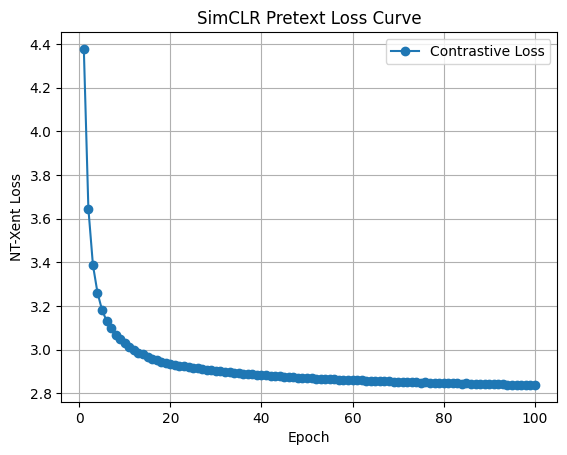

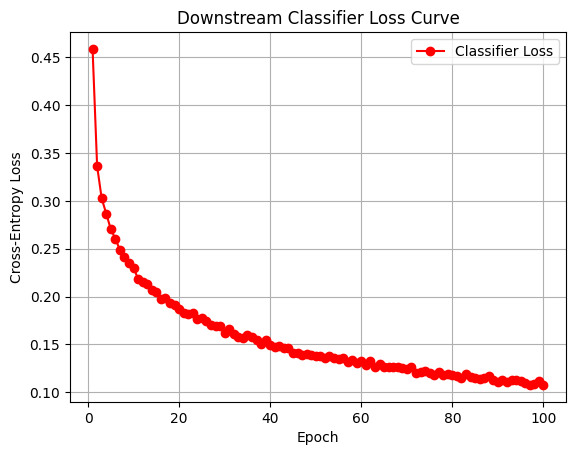

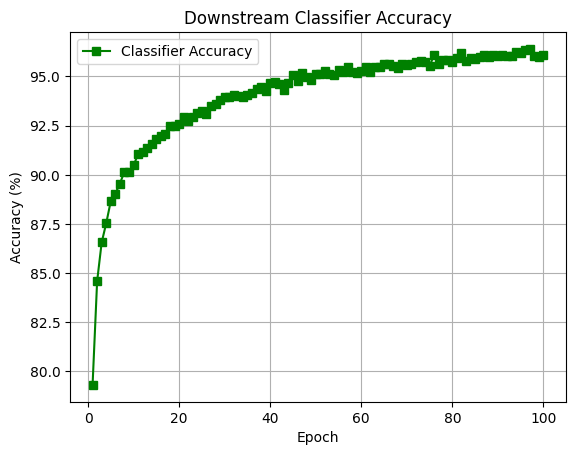

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(pretext_losses) + 1), pretext_losses, marker='o', label='Contrastive Loss')
plt.title('SimCLR Pretext Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('NT-Xent Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(range(1, len(downstream_losses) + 1), downstream_losses, marker='o', color='red', label='Classifier Loss')
plt.title('Downstream Classifier Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid()
plt.show()

plt.plot(range(1, len(downstream_accuracies) + 1), downstream_accuracies, marker='s', color='green', label='Classifier Accuracy')
plt.title('Downstream Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

# Evaluation

In [24]:
from sklearn.metrics import classification_report, accuracy_score

all_preds, all_labels = [], []
classifier.eval()
model.encoder.eval()

for imgs, labels in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        features = model.encoder(imgs)
        logits = classifier(features)
        preds = logits.argmax(dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.numpy())

class_names = ['Non-Cancer', 'Cancer']
print(classification_report(all_labels, all_preds, target_names=class_names))
print("Test Accuracy: {:.2f}%".format(accuracy_score(all_labels, all_preds) * 100))

              precision    recall  f1-score   support

  Non-Cancer       0.96      0.96      0.96      1043
      Cancer       0.96      0.95      0.96       958

    accuracy                           0.96      2001
   macro avg       0.96      0.96      0.96      2001
weighted avg       0.96      0.96      0.96      2001

Test Accuracy: 95.80%
